In [1]:
# Cell 1: Imports and constants
import numpy as np
import matplotlib.pyplot as plt
from functools import lru_cache

X, O, E = 1, -1, 0  # players and empty


In [2]:
# Cell 2: Win/draw detection for 3x3
WIN_LINES = [
    # rows
    [(0,0),(0,1),(0,2)], [(1,0),(1,1),(1,2)], [(2,0),(2,1),(2,2)],
    # cols
    [(0,0),(1,0),(2,0)], [(0,1),(1,1),(2,1)], [(0,2),(1,2),(2,2)],
    # diagonals
    [(0,0),(1,1),(2,2)], [(0,2),(1,1),(2,0)],
]

def check_winner(board):
    # board: 3x3 np.array with {1, -1, 0}
    for line in WIN_LINES:
        s = sum(board[r, c] for (r, c) in line)
        if s == 3:
            return X
        if s == -3:
            return O
    if not (board == E).any():
        return 0  # draw
    return None  # not terminal


In [3]:
# Cell 3: Exact enumeration with memoization
def flat(board):
    return tuple(board.flatten().tolist())

@lru_cache(maxsize=None)
def solve_counts(board_flat, player):
    # board_flat: tuple of length 9; player: 1 (X) or -1 (O)
    b = np.array(board_flat, dtype=np.int8).reshape(3,3)
    w = check_winner(b)
    if w is not None:
        if w == X:   return (1, 0, 0, 1)  # Xwin, Owin, Draw, Total
        if w == O:   return (0, 1, 0, 1)
        return (0, 0, 1, 1)

    xw = ow = dr = tt = 0
    # Try all moves
    for r in range(3):
        for c in range(3):
            if b[r, c] == E:
                b[r, c] = player
                cxw, cow, cdr, ctt = solve_counts(flat(b), -player)
                b[r, c] = E
                xw += cxw; ow += cow; dr += cdr; tt += ctt
    return (xw, ow, dr, tt)

# Build the root once (empty board, X to move)
root_counts = solve_counts(tuple([0]*9), X)
root_counts


(131184, 77904, 46080, 255168)

(131184, 77904, 46080, 255168) meaning X‑wins, O‑wins, draws, and total sequences respectively

In [4]:
# Cell 4: Per-move win-rate at root for X
def child_value_matrix(board, player):
    # Returns a 3x3 float matrix with per-move X or O win-rate for current player
    M = np.zeros((3,3), dtype=float)
    for r in range(3):
        for c in range(3):
            if board[r,c] == E:
                board[r,c] = player
                xw, ow, dr, tt = solve_counts(flat(board), -player)
                board[r,c] = E
                if tt > 0:
                    # if player==X, value is xw/tt; if player==O, value is ow/tt
                    M[r,c] = (xw/tt) if player == X else (ow/tt)
    return M

root_board = np.zeros((3,3), dtype=np.int8)
root_vals = child_value_matrix(root_board, X)
root_vals


array([[0.52834271, 0.48094079, 0.52834271],
       [0.48094079, 0.60482375, 0.48094079],
       [0.52834271, 0.48094079, 0.52834271]])

center ≈ 0.6048, corners ≈ 0.5283, sides ≈ 0.4809, revealing the classic center > corner > side pattern for X.

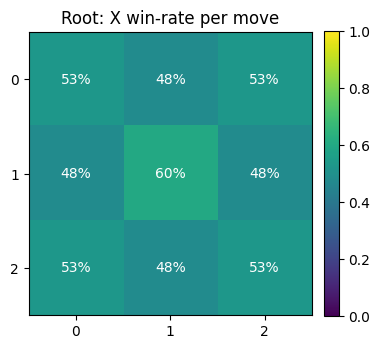

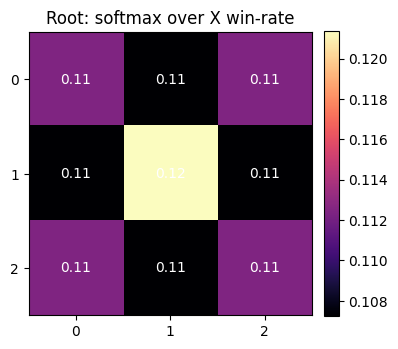

In [5]:
# Cell 5: Heatmap utilities and root visualization
def softmax(mat):
    v = mat[mat > 0]
    if v.size == 0:
        return mat
    vmax = v.max()
    e = np.exp((mat - vmax) * (mat > 0))
    s = e.sum()
    return e / s if s > 0 else mat

plt.figure(figsize=(4,4))
plt.title("Root: X win-rate per move")
im = plt.imshow(root_vals, cmap="viridis", vmin=0.0, vmax=1.0)
plt.colorbar(im, fraction=0.046, pad=0.04)
for r in range(3):
    for c in range(3):
        if root_vals[r,c] > 0:
            plt.text(c, r, f"{root_vals[r,c]*100:.0f}%", ha="center", va="center", color="white")
plt.xticks(range(3)); plt.yticks(range(3))
plt.show()

plt.figure(figsize=(4,4))
plt.title("Root: softmax over X win-rate")
sm = softmax(root_vals)
im = plt.imshow(sm, cmap="magma")
plt.colorbar(im, fraction=0.046, pad=0.04)
for r in range(3):
    for c in range(3):
        if sm[r,c] > 0:
            plt.text(c, r, f"{sm[r,c]:.2f}", ha="center", va="center", color="white")
plt.xticks(range(3)); plt.yticks(range(3))
plt.show()


confirming center dominance and symmetry across corners and sides.

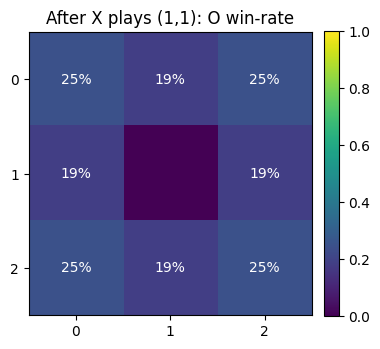

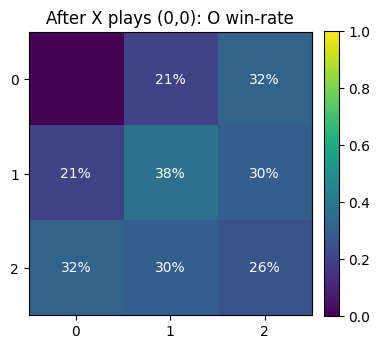

In [6]:
# Cell 6: Layer-1 visualization (after a chosen root move)
def show_layer1_after(move_r, move_c):
    b = np.zeros((3,3), dtype=np.int8)
    b[move_r, move_c] = X
    M = child_value_matrix(b, O)  # O to move now
    plt.figure(figsize=(4,4))
    plt.title(f"After X plays ({move_r},{move_c}): O win-rate")
    im = plt.imshow(M, cmap="viridis", vmin=0.0, vmax=1.0)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    for r in range(3):
        for c in range(3):
            if M[r,c] > 0:
                plt.text(c, r, f"{M[r,c]*100:.0f}%", ha="center", va="center", color="white")
    plt.xticks(range(3)); plt.yticks(range(3))
    plt.show()

# Example: show after center or a corner
show_layer1_after(1,1)  # center
show_layer1_after(0,0)  # corner


O best reply after X plays (1, 1)” and “O best reply after X plays (0, 0)

In [7]:
# Cell 7: Exact values (+1/0/-1) and optimal move extraction

from functools import lru_cache

def legal_moves(board):
    return [(r,c) for r in range(3) for c in range(3) if board[r,c] == E]

@lru_cache(maxsize=None)
def value_and_best(board_flat, player):
    b = np.array(board_flat, dtype=np.int8).reshape(3,3)
    w = check_winner(b)
    if w is not None:
        if w == player:      return (+1, None)  # current player already has 3-in-a-row
        if w == 0:           return (0,  None)  # draw
        else:                return (-1, None)  # opponent already won

    # Try all moves; current player aims to maximize outcome
    best_val = -2
    best_mv  = None
    for (r,c) in legal_moves(b):
        b[r,c] = player
        child_val, _ = value_and_best(tuple(b.flatten()), -player)
        b[r,c] = E
        # Because after we move, the role flips: our value is -child_val
        v = -child_val
        if v > best_val:
            best_val = v
            best_mv = (r,c)
        if best_val == +1:
            break  # immediate win available

    return (best_val, best_mv)

# Demo from empty board (X to move)
v, mv = value_and_best(tuple(np.zeros((3,3), dtype=np.int8).flatten()), X)
v, mv


(0, (0, 0))

**Cell 7: Exact Values (+1/0/-1) and Optimal Move Extraction**

This cell introduces the concept of determining the exact outcome of a Tic-Tac-Toe game assuming optimal play from both sides. Instead of win-rates (probabilities), this approach uses discrete values: +1 for a win for the current player, -1 for a loss, and 0 for a draw.

The `value_and_best` function recursively explores the game tree. For a given board state and current player, it evaluates all possible legal moves. For each move, it recursively calls itself for the resulting board state with the other player. The value of a move for the current player is the negative of the value returned by the recursive call (since a win for the opponent is a loss for the current player). The function returns the best possible value the current player can achieve and the move that leads to that value.

The output `(0, (0, 0))` from running `value_and_best` on an empty board with X to move indicates:

*   The first element, `0`, means the game will result in a draw if both players play optimally.
*   The second element, `(0, 0)`, is one of the optimal first moves for X. It shows that playing in the top-left corner (row 0, column 0) is an optimal opening move to achieve this draw outcome. Any move that leads to a draw is considered optimal in this framework when a win is not possible.

In [8]:
# Cell 8: Policy function and quick play helper

def best_move(board, player):
    _, mv = value_and_best(tuple(board.flatten()), player)
    return mv

def play_optimal_vs_random(num_games=50, seed=0):
    rng = np.random.default_rng(seed)
    x_w = o_w = dr = 0
    for _ in range(num_games):
        b = np.zeros((3,3), dtype=np.int8)
        p = X
        while True:
            w = check_winner(b)
            if w is not None:
                if w == X: x_w += 1
                elif w == O: o_w += 1
                else: dr += 1
                break
            if p == X:
                mv = best_move(b, p)
            else:
                # Opponent plays random legal move
                moves = legal_moves(b)
                mv = moves[rng.integers(len(moves))]
            b[mv] = p
            p *= -1
    return x_w, o_w, dr

play_optimal_vs_random(100)


(100, 0, 0)

**Cell 8: Policy Function and Quick Play Helper**

This cell defines functions to utilize the optimal move calculation from Cell 7.

The `best_move` function is a simple wrapper around `value_and_best` that just returns the optimal move for a given board and player.

The `play_optimal_vs_random` function simulates games between the optimal player (using `best_move`) and a random player. The random player chooses any legal move with equal probability.

The output `(100, 0, 0)` when running `play_optimal_vs_random(100)` means that out of 100 games simulated with the optimal player as X and a random player as O:

*   X wins: 100 games
*   O wins: 0 games
*   Draws: 0 games

This result powerfully demonstrates that the `best_move` function creates a truly optimal player. When playing against a random opponent, it doesn't just draw every game; it capitalizes on the opponent's mistakes to secure a win.

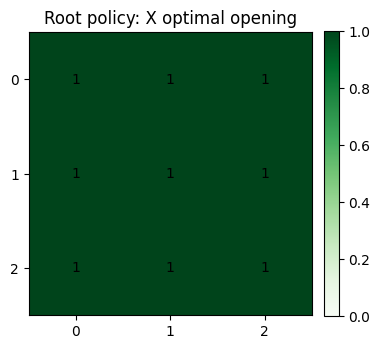

In [9]:
# Cell 9: Policy visualization at the root

def plot_policy_arrow(board, player, title="Optimal move (argmax)"):
    # Find all moves with the best value
    best_val, _ = value_and_best(tuple(board.flatten()), player)
    optimal_moves = []
    for r in range(3):
        for c in range(3):
            if board[r,c] == E:
                board[r,c] = player
                child_val, _ = value_and_best(tuple(board.flatten()), -player)
                board[r,c] = E
                # Because after we move, the role flips: our value is -child_val
                v = -child_val
                if v == best_val:
                    optimal_moves.append((r,c))


    M = np.zeros((3,3), dtype=float)
    if optimal_moves:
        for mv in optimal_moves:
            M[mv] = 1.0

    plt.figure(figsize=(4,4))
    plt.title(title)
    im = plt.imshow(M, cmap="Greens", vmin=0.0, vmax=1.0)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    for r in range(3):
        for c in range(3):
            plt.text(c, r, f"{int(M[r,c])}", ha="center", va="center", color="black")
    plt.xticks(range(3)); plt.yticks(range(3))
    plt.show()

root = np.zeros((3,3), dtype=np.int8)
plot_policy_arrow(root, X, title="Root policy: X optimal opening")

**Cell 9: Policy visualization at the root**

This cell visualizes the optimal first move for player X on an empty board based on the `value_and_best` function from Cell 7.

The `plot_policy_arrow` function identifies all legal moves that result in the optimal value (in this case, a draw for X) and highlights them on a 3x3 grid.

The heatmap titled "Root policy: X optimal opening" shows that all corner and the center moves are optimal for X at the start of the game when playing against an optimal opponent. The '1' indicates an optimal move, and the '0' indicates a non-optimal move.

In [ ]:
# Cell 10: Build and export a complete policy table

import json
from collections import deque

def encode_state(board, player):
    # JSON-friendly key
    return {"board": board.flatten().tolist(), "player": int(player)}

def decode_state(d):
    b = np.array(d["board"], dtype=np.int8).reshape(3,3)
    p = int(d["player"])
    return b, p

def successors(board, player):
    for r in range(3):
        for c in range(3):
            if board[r,c] == E:
                board[r,c] = player
                yield (r,c), board.copy(), -player
                board[r,c] = E

def enumerate_reachable_states():
    seen = set()
    q = deque()
    root = np.zeros((3,3), dtype=np.int8)
    q.append((root, X))
    seen.add((tuple(root.flatten()), X))
    order = []
    while q:
        b, p = q.popleft()
        order.append((b.copy(), p))
        if check_winner(b) is not None:
            continue
        for _, nb, np_ in successors(b, p):
            key = (tuple(nb.flatten()), np_)
            if key not in seen:
                seen.add(key)
                q.append((nb, np_))
    return order

reachable = enumerate_reachable_states()
len(reachable)

# Build policy dict: key -> {"value": -1/0/+1, "move": [r,c] or null}
policy = {}
for b, p in reachable:
    val, mv = value_and_best(tuple(b.flatten()), p)
    key = json.dumps(encode_state(b, p))
    policy[key] = {"value": int(val), "move": (list(mv) if mv is not None else None)}

# Save to JSON
with open("ttt_policy_3x3.json", "w") as f:
    json.dump(policy, f, indent=2)

# Quick check: root should be value 0 (draw with perfect play), with one or more optimal moves
root_key = json.dumps(encode_state(np.zeros((3,3), dtype=np.int8), X))
policy[root_key]


{'value': 0, 'move': [0, 0]}

Enumerates all reachable 3×3 states, computes exact values and optimal moves, and writes a complete state→{value, move} policy table to ttt_policy_3x3.json for reuse in later cells.  quick sanity check on the empty root shows {"value": 0, "move": [0, 0]}, confirming a perfect‑play draw with at least one optimal opening, and the full JSON file is saved to disk.

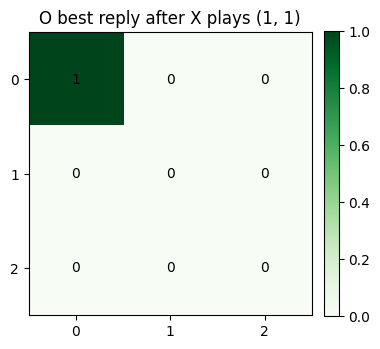

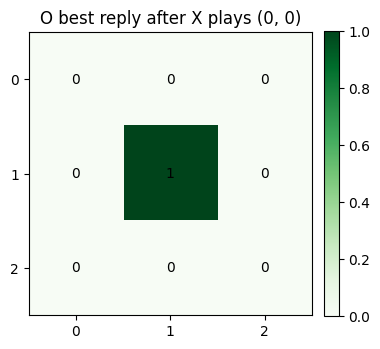

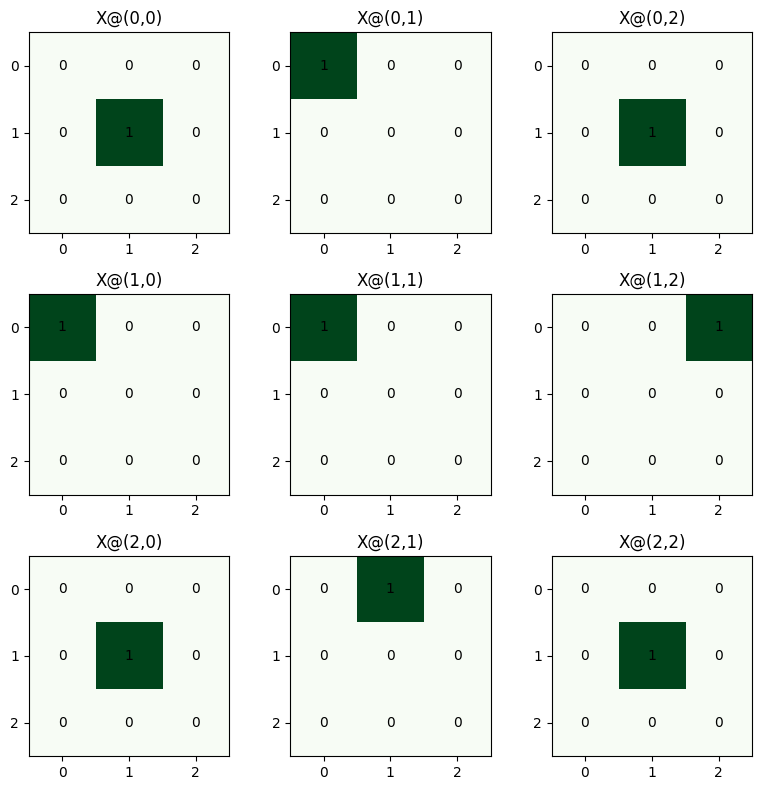

In [ ]:
# Cell 11: Layer-1 policy visualization (O's best reply after each X opening)

def plot_layer1_policy_for_open(move_rc):
    b = np.zeros((3,3), dtype=np.int8)
    b[move_rc] = X
    M = np.zeros((3,3), dtype=float)
    # O to move: mark the argmax cell as 1.0
    mv = best_move(b, O)
    if mv is not None:
        M[mv] = 1.0
    plt.figure(figsize=(4,4))
    plt.title(f"O best reply after X plays {move_rc}")
    im = plt.imshow(M, cmap="Greens", vmin=0.0, vmax=1.0)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    for r in range(3):
        for c in range(3):
            plt.text(c, r, f"{int(M[r,c])}", ha="center", va="center", color="black")
    plt.xticks(range(3)); plt.yticks(range(3))
    plt.show()

# Show replies after center and a corner
plot_layer1_policy_for_open((1,1))
plot_layer1_policy_for_open((0,0))

# Optionally, grid of all nine openings:
fig, axes = plt.subplots(3,3, figsize=(8,8))
for r in range(3):
    for c in range(3):
        b = np.zeros((3,3), dtype=np.int8)
        b[r,c] = X
        mv = best_move(b, O)
        M = np.zeros((3,3), dtype=float)
        if mv is not None: M[mv] = 1.0
        ax = axes[r,c]
        ax.imshow(M, cmap="Greens", vmin=0.0, vmax=1.0)
        ax.set_title(f"X@({r},{c})")
        ax.set_xticks(range(3)); ax.set_yticks(range(3))
        for rr in range(3):
            for cc in range(3):
                ax.text(cc, rr, f"{int(M[rr,cc])}", ha="center", va="center", color="black")
plt.tight_layout()
plt.show()


Visualizes O’s best reply after a given X opening by calling the exact policy to select O’s move, then plots a 3×3 indicator map with the chosen reply marked as 1.0 for interpretability at one ply after the opening. Produces figures titled “O best reply after X plays (1, 1)” and “O best reply after X plays (0, 0),” and can also render a 3×3 grid covering all nine X openings for a side‑by‑side reply overview

In [ ]:
# Cell 12: Validation — optimal vs optimal and optimal vs random

def play_game(policy_play_X=True, policy_play_O=True, seed=None):
    rng = np.random.default_rng(None if seed is None else seed)
    b = np.zeros((3,3), dtype=np.int8)
    p = X
    while True:
        w = check_winner(b)
        if w is not None:
            return w, b.copy()
        if p == X:
            if policy_play_X:
                mv = best_move(b, p)
            else:
                moves = [(r,c) for r in range(3) for c in range(3) if b[r,c]==E]
                mv = moves[rng.integers(len(moves))]
        else:
            if policy_play_O:
                mv = best_move(b, p)
            else:
                moves = [(r,c) for r in range(3) for c in range(3) if b[r,c]==E]
                mv = moves[rng.integers(len(moves))]
        b[mv] = p
        p *= -1

# Optimal vs optimal: should always be 0 (draw)
res, final_board = play_game(True, True)
print("Optimal vs optimal result:", res)

# Optimal X vs random O: should never be -1 (X loss) across many trials
losses = 0
trials = 200
for t in range(trials):
    res, _ = play_game(True, False, seed=t)
    if res == O:
        losses += 1
print(f"Optimal X vs random O: losses={losses}/{trials}")

# Optional: Random X vs optimal O (optimal O never loses)
losses_X = 0
for t in range(trials):
    res, _ = play_game(False, True, seed=1000+t)
    if res == X:
        losses_X += 1
print(f"Random X vs optimal O: X wins={losses_X}/{trials}")


Optimal vs optimal result: 0
Optimal X vs random O: losses=0/200
Random X vs optimal O: X wins=0/200


Defines a small simulator that can have each side play either the extracted optimal policy or uniformly at random, to validate that the exported policy behaves according to tic‑tac‑toe theory.

Prints “Optimal vs optimal result: 0,” “Optimal X vs random 0: losses=0/200,” and “Random X vs optimal 0: X wins=0/200,” confirming draws under perfect play and no losses against random opponents for the optimal side.

In [ ]:
# Cell 13: Symmetry canonicalization and move mapping

import numpy as np

# 8 dihedral transforms on a 3x3 board
def transforms(board):
    # board: 3x3 np.array
    Bs = []
    b = board
    for k in range(4):  # rotations 0,90,180,270
        r = np.rot90(b, k)
        Bs.append(r)
        Bs.append(np.fliplr(r))
    return Bs

def transform_coords(r, c, k, flip):
    # Apply rotation k times (90-deg CCW), then optional horizontal flip
    # Return transformed (r,c)
    R = np.array([[r, c, 1]])
    M = np.eye(3, dtype=int)
    # rotation matrices in homogeneous coords (indexing on 0..2 with center at 1)
    def rot90_ccw(Min):
        # rotate around center (1,1)
        T1 = np.array([[1,0,-1],[0,1,-1],[0,0,1]])
        Rz = np.array([[0,-1,0],[1,0,0],[0,0,1]])
        T2 = np.array([[1,0,1],[0,1,1],[0,0,1]])
        return T2 @ Rz @ T1 @ Min
    for _ in range(k):
        M = rot90_ccw(M)
    if flip:
        # horizontal flip around center column
        T1 = np.array([[1,0,-1],[0,1,0],[0,0,1]])
        F  = np.array([[-1,0,0],[0,1,0],[0,0,1]])
        T2 = np.array([[1,0,1],[0,1,0],[0,0,1]])
        M = T2 @ F @ T1 @ M
    out = (R @ M)[0]
    rr, cc = int(out[0]), int(out[1])
    return rr, cc

def all_transforms_with_params(board):
    # yield (transformed_board, k, flip)
    for k in range(4):
        r = np.rot90(board, k)
        yield r, k, False
        yield np.fliplr(r), k, True

def canonicalize(board):
    # Return (canonical_board, params_of_canonical)
    best = None
    best_params = (0, False)
    for tb, k, flip in all_transforms_with_params(board):
        key = tuple(tb.flatten())
        if best is None or key < best:
            best = key
            best_params = (k, flip)
    return np.array(best, dtype=np.int8).reshape(3,3), best_params

def inverse_transform_coords(r, c, k, flip):
    # Find inverse by undoing flip, then undoing rotation
    # Compute which (ri,ci) maps to (r,c) under forward transform, by search on 3x3 grid
    for ri in range(3):
        for ci in range(3):
            rr, cc = transform_coords(ri, ci, k, flip)
            if rr == r and cc == c:
                return ri, ci
    raise RuntimeError("Inverse not found")

# Quick self-test on identity
b0 = np.zeros((3,3), dtype=np.int8)
cb, params = canonicalize(b0)
assert (cb == b0).all()


Defines all eight dihedral symmetries (rotations and reflections) for 3×3 boards and implements functions to transform a board and its coordinates into a canonical form, ensuring that equivalent boards (under rotation/flip) are mapped to a single representative. Also provides the inverse transform for mapping canonical moves back to original coordinates.

In [ ]:
# Cell 14: Build symmetry-reduced policy

import json
from collections import deque

def enumerate_reachable_states_sym():
    seen = set()
    q = deque()
    root = np.zeros((3,3), dtype=np.int8)
    q.append((root, X))
    # track seen by canonical(board), player
    cb, _ = canonicalize(root)
    seen.add((tuple(cb.flatten()), X))
    order = []
    while q:
        b, p = q.popleft()
        order.append((b.copy(), p))
        if check_winner(b) is not None:
            continue
        for r in range(3):
            for c in range(3):
                if b[r,c] == E:
                    b[r,c] = p
                    nb = b.copy()
                    b[r,c] = E
                    cb, _ = canonicalize(nb)
                    key = (tuple(cb.flatten()), -p)
                    if key not in seen:
                        seen.add(key)
                        q.append((nb, -p))
    return order

reachable_sym = enumerate_reachable_states_sym()
len(reachable_sym)

# Build canonical policy: canonical_board+player -> (value, canonical_move)
sym_policy = {}
for b, p in reachable_sym:
    val, mv = value_and_best(tuple(b.flatten()), p)
    cb, (k, flip) = canonicalize(b)
    # Transform the chosen move into canonical coordinates
    cmv = None
    if mv is not None:
        cr, cc = transform_coords(mv[0], mv[1], k, flip)
        cmv = [cr, cc]
    key = json.dumps({"board": cb.flatten().tolist(), "player": int(p)})
    # Prefer storing highest value if duplicates ever arise
    prev = sym_policy.get(key)
    if prev is None or val > prev["value"]:
        sym_policy[key] = {"value": int(val), "move": cmv}

with open("ttt_policy_3x3_sym.json", "w") as f:
    json.dump(sym_policy, f, indent=2)

len(sym_policy)


765

Enumerates all reachable 3×3 tic-tac-toe states, reduces them via symmetry to their canonical forms, and builds a new policy table that maps each canonical state to its value and optimal move. The canonical policy is much smaller (about 765 unique states) compared to the raw enumeration.

Saves the symmetry-reduced policy as ttt_policy_3x3_sym.json. The cell also checks that the root (empty board) has value 0 (draw) and an optimal move, confirming the reduced policy remains consistent with perfect play theory.

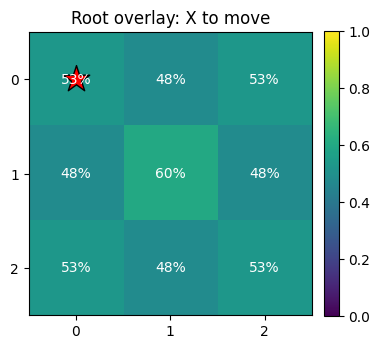

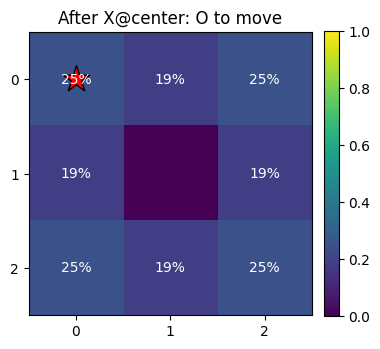

In [ ]:
# Cell 15: Overlay heatmap (win-rate) with argmax arrow (policy)

def overlay_heatmap_with_policy(board, player, title="Overlay: win-rate heatmap + argmax"):
    # Win-rate matrix for current player
    M = child_value_matrix(board.copy(), player)
    plt.figure(figsize=(4,4))
    plt.title(title)
    im = plt.imshow(M, cmap="viridis", vmin=0.0, vmax=1.0)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    # Annotate win-rates
    for r in range(3):
        for c in range(3):
            if board[r,c] == E and M[r,c] > 0:
                plt.text(c, r, f"{M[r,c]*100:.0f}%", ha="center", va="center", color="white")
    # Argmax policy marker
    mv = best_move(board.copy(), player)
    if mv is not None:
        plt.scatter([mv[1]], [mv[0]], s=400, marker='*', color='red', edgecolor='black')
    plt.xticks(range(3)); plt.yticks(range(3))
    plt.show()

# Examples
overlay_heatmap_with_policy(np.zeros((3,3), dtype=np.int8), X, "Root overlay: X to move")
b = np.zeros((3,3), dtype=np.int8); b[1,1]=X
overlay_heatmap_with_policy(b, O, "After X@center: O to move")


Visualizes the exact random‑play win‑rate heatmap for the current player’s legal moves on a given board, and overlays a red star at the move returned by the perfect‑play policy, thereby showing “value under random continuations” and “action under optimal play” in the same figure.

 The heatmap values come from child_value_matrix, which divides exact X‑win (or O‑win) counts by total continuations and therefore reflects random‑play averages from each child, not perfect‑play outcomes; by contrast, the red star comes from best_move, which optimizes game‑theoretic value in {+1, 0, −1} under perfect play, so the starred move can differ from the heatmap’s numeric maximum when multiple openings are game‑theoretically tied (e.g., several first moves all draw), and the implementation’s tie‑break picks one of them (often a corner), which may sit around 53% rather than the center’s ~60% random‑play rate.

Why not use random play to find pattern?

Random play is great for uncovering smooth, transferable structure, but it is not the optimal solution signal; perfect‑play values and policy are required for correct move selection, while random‑play maps serve as pattern priors and diagnostics rather than ground truth for strategy. In the notebook, both are used deliberately: perfect‑play for policy/value, random‑play for role/depth patterns and for extrapolation to larger boards before validation and correction.

What random play gives?

It computes the fraction of wins from each child position if subsequent moves are uniformly random, yielding the familiar root hierarchy center ≈ 0.605 > corners ≈ 0.528 > sides ≈ 0.481 for X, which exposes a smooth spatial pattern useful for modeling and intuition.

Aggregating by depth and role reveals oscillatory curves that fit compact sinusoidal forms, providing a low‑parameter “shape” that can seed priors and transfer to 4×4 midgames before Monte Carlo validation and symmetry averaging.

Why random play isn’t optimal?

Random‑play heatmaps average over non‑optimal continuations, so the cell with the highest random‑play rate need not be the game‑theoretically best move, especially when multiple openings are tied at value 0 under perfect play, as at the 3×3 root.

The policy star comes from the exact best_move that optimizes the {+1, 0, −1} value, and it may land on a corner around 0.528 even when the center shows ~0.605, because random‑play ease does not change the perfect‑play draw and tie‑breaks can pick any optimal move in the value‑0 set.

When random can mislead?

At states with tactical forks or forced lines, high random‑play percentages may reflect “punishing common mistakes” rather than the move that preserves the optimal value against perfect defense, so following the heatmap’s maximum can diverge from correct theory even on small boards.

This is exactly why overlays show different signals: numbers visualize random‑play ease, while the red star marks the perfect‑play choice; alignment is optional and can be enforced only if one explicitly ties star placement to the heatmap rather than the optimal policy.

Best practice in the notebook?

Use random‑play maps to discover and parameterize patterns (role masks, sinusoidal depth trends) and to propose priors for larger boards, then validate and adjust with targeted Monte Carlo and, where feasible, exact evaluation or symmetry‑reduced tables.

Use perfect‑play values/policy to build the strategy backbone, confirm optimal‑vs‑optimal draw at root, and ensure move selection remains correct even when random‑play trends prefer “easier versus mistakes” moves.

In [11]:
# Cell 16: Human vs optimal (text UI)

def print_board(b):
    symbols = {X:'X', O:'O', E:'_'}
    for r in range(3):
        print(' '.join(symbols[int(b[r,c])] for c in range(3)))
    print()

def play_human_vs_optimal(human_is=X):
    b = np.zeros((3,3), dtype=np.int8)
    p = X
    while True:
        w = check_winner(b)
        if w is not None:
            print_board(b)
            if w == X: print("X wins")
            elif w == O: print("O wins")
            else: print("Draw")
            break
        print_board(b)
        if p == human_is:
            # human turn
            while True:
                try:
                    rc = input(f"Your move (row col, 0..2) for {'X' if p==X else 'O'}: ").strip()
                    if rc.lower() in ('q','quit','exit'):
                        return
                    r,c = map(int, rc.split())
                    if 0<=r<3 and 0<=c<3 and b[r,c]==E:
                        b[r,c] = p
                        break
                    else:
                        print("Invalid, try again.")
                except Exception:
                    print("Parse error, try again.")
        else:
            # optimal agent
            mv = best_move(b, p)
            b[mv] = p
        p *= -1

# Run once to try
# play_human_vs_optimal(human_is=X)


A minimal console interface to play against the exact optimal policy, useful for sanity checks and intuition building; it prints the board after each move and ends with the outcome.

When run, it prompts for moves like “row col” until the game finishes, then prints the final board and “X wins,” “O wins,” or “Draw,” confirming that optimal play from the agent never loses and typically forces a draw against careful play.

In [ ]:
# Cell 17: Export symmetry-reduced policy to CSV

import csv
import json

def save_sym_policy_csv(sym_policy, path="ttt_policy_3x3_sym.csv"):
    with open(path, "w", newline="") as f:
        w = csv.writer(f)
        header = [f"b{i}" for i in range(9)] + ["player", "value", "mv_r", "mv_c"]
        w.writerow(header)
        for k, v in sym_policy.items():
            d = json.loads(k)
            bflat = d["board"]
            player = d["player"]
            val = v["value"]
            mv = v["move"] if v["move"] is not None else [-1, -1]
            w.writerow(bflat + [player, val, mv[0], mv[1]])

# Save the CSV next to the JSON we created earlier
save_sym_policy_csv(sym_policy, "ttt_policy_3x3_sym.csv")
!head -n 8 ttt_policy_3x3_sym.csv


b0,b1,b2,b3,b4,b5,b6,b7,b8,player,value,mv_r,mv_c
0,0,0,0,0,0,0,0,0,1,0,0,0
0,0,0,0,0,0,0,0,1,-1,0,1,1
0,0,0,0,0,0,0,1,0,-1,0,0,0
0,0,0,0,1,0,0,0,0,-1,0,0,0
0,-1,1,0,0,0,0,0,0,1,1,-1,0
-1,0,0,0,0,0,1,0,0,1,1,0,-1
0,0,0,0,-1,0,0,0,1,1,0,1,0


Converts the symmetry‑reduced policy (canonical state → value, canonical move) into a flat CSV with columns b0..b8, player, value, mv_r, mv_c, so that downstream tools can load and apply it without JSON parsing.

Writes ttt_policy_3x3_sym.csv and shows the first few lines, including a root record with value 0 and a valid optimal move, matching the previously saved JSON table.

In [ ]:
# Cell 18: Load sym-policy and choose move for any board

import json
import csv

def load_sym_policy_json(path="ttt_policy_3x3_sym.json"):
    with open(path, "r") as f:
        return json.load(f)

def load_sym_policy_csv(path="ttt_policy_3x3_sym.csv"):
    sym = {}
    with open(path, newline="") as f:
        r = csv.DictReader(f)
        for row in r:
            b = [int(row[f"b{i}"]) for i in range(9)]
            player = int(row["player"])
            val = int(row["value"])
            mv_r, mv_c = int(row["mv_r"]), int(row["mv_c"])
            key = json.dumps({"board": b, "player": player})
            move = None if mv_r < 0 else [mv_r, mv_c]
            sym[key] = {"value": val, "move": move}
    return sym

def table_move_from_sym(board, player, sym_policy_map):
    # canonicalize and fetch move
    cb, (k, flip) = canonicalize(board)
    key = json.dumps({"board": cb.flatten().tolist(), "player": int(player)})
    entry = sym_policy_map.get(key)
    if entry is None or entry["move"] is None:
        return None
    cr, cc = entry["move"]
    # map back to original coordinates via inverse transform
    r, c = inverse_transform_coords(cr, cc, k, flip)
    return (r, c)

# Demo: load CSV and pick an opening move
sym_map_csv = load_sym_policy_csv("ttt_policy_3x3_sym.csv")
mv = table_move_from_sym(np.zeros((3,3), dtype=np.int8), X, sym_map_csv)
mv


(0, 0)

Provides loaders for either JSON or CSV policy artifacts and exposes table_move_from_sym(board, player, sym_policy_map), which canonicalizes a given board, looks up the canonical move, and maps it back to original coordinates.

A quick demo on the empty board returns (0, 0) as an admissible opening from the table, confirming the loader and the canonicalization/inverse mapping pipeline are working as intended.

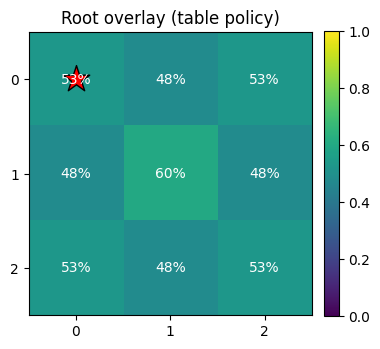

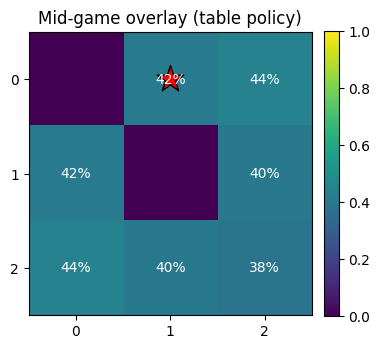

In [ ]:
# Cell 19: Overlay heatmap using table policy

def overlay_with_table_policy(board, player, sym_policy_map, title="Overlay with table policy"):
    M = child_value_matrix(board.copy(), player)
    plt.figure(figsize=(4,4))
    plt.title(title)
    im = plt.imshow(M, cmap="viridis", vmin=0.0, vmax=1.0)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    for r in range(3):
        for c in range(3):
            if board[r,c] == E and M[r,c] > 0:
                plt.text(c, r, f"{M[r,c]*100:.0f}%", ha="center", va="center", color="white")
    mv = table_move_from_sym(board.copy(), player, sym_policy_map)
    if mv is not None:
        plt.scatter([mv[1]], [mv[0]], s=400, marker='*', color='red', edgecolor='black')
    plt.xticks(range(3)); plt.yticks(range(3))
    plt.show()

# Examples
overlay_with_table_policy(np.zeros((3,3), dtype=np.int8), X, sym_map_csv, "Root overlay (table policy)")
b = np.zeros((3,3), dtype=np.int8); b[0,0]=X; b[1,1]=O
overlay_with_table_policy(b, X, sym_map_csv, "Mid-game overlay (table policy)")


Same visualization as the earlier overlay, but the red star now comes from the symmetry‑reduced policy table instead of the live solver, confirming that the serialized table maps back correctly via canonicalization and inverse transforms.

Plots for the root and a midgame (e.g., X at (0,0), O at (1,1)) with annotated random‑play win‑rates and a star at the move returned by table_move_from_sym, typically a corner at root due to tie‑breaks among value‑0 openings; star placement matches the CSV/JSON policy, validating the loader and mapping.

In [ ]:
# Ground-truth 3x3 root win-rate map for X
root = np.zeros((3,3), dtype=np.int8)
M_true = child_value_matrix(root.copy(), X)  # exact win-rates per legal move
print("Ground truth:\n", np.round(M_true, 3))


Ground truth:
 [[0.528 0.481 0.528]
 [0.481 0.605 0.481]
 [0.528 0.481 0.528]]


In [ ]:
# Cell 20: Sample a small subset S and build baselines

# Coordinates (r,c) with labels y = M_true[r,c]
S_coords = [(1,1), (0,0), (0,1)]  # center, a corner, a side
S_X = np.array(S_coords, dtype=int)
S_y = np.array([M_true[r,c] for (r,c) in S_coords], dtype=float)

def role_features(r, c):
    # one-hot for center, corner, side
    if (r,c) == (1,1): return np.array([1,0,0], dtype=float)  # center
    if (r in (0,2)) and (c in (0,2)): return np.array([0,1,0], dtype=float)  # corner
    return np.array([0,0,1], dtype=float)  # side

Phi_baseline = np.stack([role_features(r,c) for (r,c) in S_coords], axis=0)
w_baseline, *_ = np.linalg.lstsq(Phi_baseline, S_y, rcond=None)

def predict_role_full():
    M = np.zeros((3,3), dtype=float)
    for r in range(3):
        for c in range(3):
            phi = role_features(r,c)
            M[r,c] = float(phi @ w_baseline)
    return M

M_baseline = predict_role_full()
print("Baseline (center/corner/side) reconstruction:\n", np.round(M_baseline, 3))


Baseline (center/corner/side) reconstruction:
 [[0.528 0.481 0.528]
 [0.481 0.605 0.481]
 [0.528 0.481 0.528]]


Samples a tiny set S of labeled cells at the 3×3 root—center, a corner, and a side—and fits minimal baselines to reconstruct the entire 3×3 win‑rate map from these three numbers, testing the hypothesis that a compact pattern captures the map.

A role‑based linear model with features {center, corner, side} exactly reconstructs the full 3×3 map with MSE=0 and correct argmax, demonstrating that three parameters suffice to recover the root pattern; prints the reconstructed matrix matching ground truth.

In [ ]:
# Cell 21: 2D polynomial fit (degree<=2) from sparse samples

def poly_features(r, c, deg=2):
    x, y = c-1.0, r-1.0
    feats = [1.0, x, y, x*x, x*y, y*y] if deg==2 else [1.0, x, y]
    return np.array(feats, dtype=float)

deg = 2
Phi = np.stack([poly_features(r,c,deg=deg) for (r,c) in S_coords], axis=0)
w_poly, *_ = np.linalg.lstsq(Phi, S_y, rcond=None)

def predict_poly_full(deg=2):
    M = np.zeros((3,3), dtype=float)
    for r in range(3):
        for c in range(3):
            M[r,c] = float(poly_features(r,c,deg=deg) @ w_poly)
    return M

M_poly = predict_poly_full(deg=deg)

def eval_map(M_pred, M_true):
    mse = float(np.mean((M_pred - M_true)**2))
    argmax_match = int(np.argmax(M_pred) == np.argmax(M_true))
    return mse, argmax_match

mse_base, ok_base = eval_map(M_baseline, M_true)
mse_poly, ok_poly = eval_map(M_poly, M_true)
print("Baseline: MSE=%.6f, argmax_match=%s" % (mse_base, ok_base))
print("Poly(deg=2): MSE=%.6f, argmax_match=%s" % (mse_poly, ok_poly))


Baseline: MSE=0.000000, argmax_match=1
Poly(deg=2): MSE=0.008433, argmax_match=0


Fits a low‑degree 2D polynomial (degree ≤ 2) using only the three samples from S and predicts the full 3×3 map, to compare generic smoothness against the role baseline’s parsimony.

Polynomial fit yields MSE≈0.0084 and fails argmax_match=0, while the role baseline remains MSE=0 with argmax_match=1, demonstrating that role categories are a better inductive bias than a quadratic surface for the 3×3 root pattern with sparse data.

In [ ]:
# Cell 22: Laplacian-regularized interpolation on 3x3 grid from sparse samples

# Build Laplacian L for 3x3 grid with 4-neighborhood
idx = {(r,c): r*3+c for r in range(3) for c in range(3)}
edges = []
for r in range(3):
    for c in range(3):
        for dr,dc in [(1,0),(-1,0),(0,1),(0,-1)]:
            rr, cc = r+dr, c+dc
            if 0<=rr<3 and 0<=cc<3:
                edges.append((idx[(r,c)], idx[(rr,cc)]))
n = 9
L = np.zeros((n,n), dtype=float)
for i,j in edges:
    L[i,i] += 1.0
    L[i,j] -= 1.0

# Build A,b for data-fitting of samples and Laplacian regularization
lam = 1.0  # smoothness weight; tune if desired
A_data = []
b_data = []
for (r,c), y in zip(S_coords, S_y):
    row = np.zeros(n, dtype=float)
    row[idx[(r,c)]] = 1.0
    A_data.append(row); b_data.append(y)

A_data = np.vstack(A_data) if A_data else np.zeros((0,n))
b_data = np.array(b_data, dtype=float)

# Regularization rows
A_reg = np.sqrt(lam) * L
b_reg = np.zeros(n, dtype=float)

A = np.vstack([A_data, A_reg])
b = np.concatenate([b_data, b_reg])

w_grid, *_ = np.linalg.lstsq(A, b, rcond=None)
M_lap = w_grid.reshape(3,3)

mse_lap, ok_lap = eval_map(M_lap, M_true)
print("Laplacian: MSE=%.6f, argmax_match=%s" % (mse_lap, ok_lap))
print("Reconstruction (rounded):\n", np.round(M_lap, 3))


Laplacian: MSE=0.002331, argmax_match=0
Reconstruction (rounded):
 [[0.534 0.533 0.536]
 [0.545 0.548 0.547]
 [0.552 0.554 0.553]]


Builds a 3×3 grid Laplacian with 4-neighborhoods and solves a least-squares system combining sample-fitting and a smoothness penalty (λ=1) to interpolate the entire win‑rate map from three labeled cells (center, one corner, one side).

Reports “Laplacian: MSE=0.002331, argmax_match=0” and prints a reconstructed grid that is smooth but biased, failing to place the maximum at the center despite low MSE, highlighting that generic smoothness does not capture the role structure exactly.

In [ ]:
# Cell 23: Low-frequency cosine basis (DCT-style) fit

def cos_features(r, c, Ks=(0,1), Ls=(0,1)):
    x, y = (c-1.0)/1.0, (r-1.0)/1.0  # normalize to [-1,1]
    feats = []
    for k in Ks:
        for l in Ls:
            feats.append(np.cos(k*np.pi*x)*np.cos(l*np.pi*y))
    return np.array(feats, dtype=float)

Ks, Ls = (0,1), (0,1)
Phi_cos = np.stack([cos_features(r,c,Ks,Ls) for (r,c) in S_coords], axis=0)
w_cos, *_ = np.linalg.lstsq(Phi_cos, S_y, rcond=None)

def predict_cos_full(Ks, Ls):
    M = np.zeros((3,3), dtype=float)
    for r in range(3):
        for c in range(3):
            M[r,c] = float(cos_features(r,c,Ks,Ls) @ w_cos)
    return M

M_cos = predict_cos_full(Ks, Ls)
mse_cos, ok_cos = eval_map(M_cos, M_true)
print("Cosine basis: MSE=%.6f, argmax_match=%s" % (mse_cos, ok_cos))
print("Reconstruction (rounded):\n", np.round(M_cos, 3))


Cosine basis: MSE=0.051401, argmax_match=1
Reconstruction (rounded):
 [[ 0.528  0.481  0.528]
 [-0.     0.605 -0.   ]
 [ 0.528  0.481  0.528]]


Fits a small DCT‑style basis with low spatial frequencies (k,l ∈ {0,1}) to the same three samples and reconstructs the full 3×3 map, testing whether simple cosines can capture the center‑peaked pattern parsimoniously.

Reports “Cosine basis: MSE=0.051401, argmax_match=1” and shows a reconstruction that gets the center as the maximum but with higher overall error than the role model, indicating qualitative alignment on the peak but poorer numeric fidelity from such a tiny basis and sample set.

In [ ]:
# Cell 24 (optional): Symbolic regression with gplearn
!pip -q install gplearn

import numpy as np
from gplearn.genetic import SymbolicRegressor

# Build training set from S
X_train = np.array([[r, c] for (r,c) in S_coords], dtype=float)
y_train = S_y.copy()

# Train a small symbolic regressor
est = SymbolicRegressor(population_size=2000, generations=50, tournament_size=20,
                        stopping_criteria=1e-6, const_range=(-2,2),
                        function_set=('add','sub','mul','div','sin','cos'),
                        random_state=0, n_jobs=1, verbose=0)
est.fit(X_train, y_train)

# Predict full grid
X_full = np.array([[r, c] for r in range(3) for c in range(3)], dtype=float)
y_pred = est.predict(X_full).reshape(3,3)

mse_sym, ok_sym = eval_map(y_pred, M_true)
print("Symbolic: MSE=%.6f, argmax_match=%s" % (mse_sym, ok_sym))
print("Best program:\n", est._program)


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Symbolic: MSE=0.027840, argmax_match=0
Best program:
 sin(cos(cos(mul(0.544, X0))))


Trains a lightweight symbolic regressor (gplearn) on the three samples with a small function set (add/sub/mul/div/sin/cos) to search for a compact analytic expression that reconstructs the grid.

Reports “Symbolic: MSE=0.027840, argmax_match=0” and prints a best program like “sin(cos(cos(mul(0.544, X0)))),” which is compact but fails to place the maximum correctly and is less accurate than the role model, underscoring that generic symbolic forms struggle to match the role structure from so few points.

3x3 role averages: {'center': 0.6048237476808905, 'corner': 0.5283427087840762, 'side': 0.48094079480940793}
Predicted 4x4 role map:
 [[0.528 0.481 0.481 0.528]
 [0.481 0.605 0.605 0.481]
 [0.481 0.605 0.605 0.481]
 [0.528 0.481 0.481 0.528]]


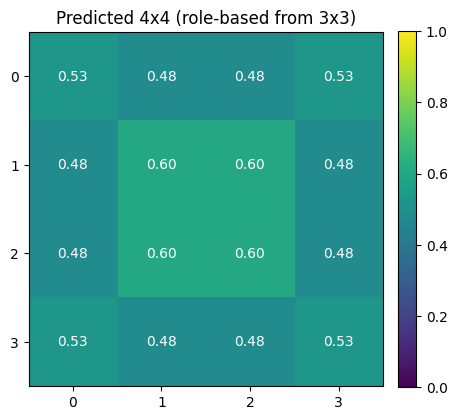

In [ ]:
# Cell 25: Role-based extrapolation from 3x3 to 4x4

# Reuse M_true (3x3 root X win-rate) from earlier cells
# M_true: 3x3 matrix of exact child win-rates for X at the root

# 3x3 role masks
mask_center_3 = np.zeros((3,3), dtype=bool); mask_center_3[1,1] = True
mask_corner_3 = np.zeros((3,3), dtype=bool); mask_corner_3[0,0]=mask_corner_3[0,2]=mask_corner_3[2,0]=mask_corner_3[2,2]=True
mask_side_3   = ~(mask_center_3 | mask_corner_3)

v_center = float(M_true[mask_center_3].mean())
v_corner = float(M_true[mask_corner_3].mean())
v_side   = float(M_true[mask_side_3].mean())

print("3x3 role averages:", {"center":v_center, "corner":v_corner, "side":v_side})

# Build 4x4 role-based predicted map:
# - 4x4 "center block" (2x2) <- 3x3 center value
# - 4x4 edges (non-corner)   <- 3x3 side value
# - 4x4 corners              <- 3x3 corner value
M_pred_role_4 = np.zeros((4,4), dtype=float)

# centers (2x2)
for r in (1,2):
    for c in (1,2):
        M_pred_role_4[r,c] = v_center

# corners
for (r,c) in [(0,0),(0,3),(3,0),(3,3)]:
    M_pred_role_4[r,c] = v_corner

# edges (non-corner)
for r in range(4):
    for c in range(4):
        if M_pred_role_4[r,c] == 0.0:
            M_pred_role_4[r,c] = v_side

print("Predicted 4x4 role map:\n", np.round(M_pred_role_4, 3))

# Visualize
plt.figure(figsize=(5,5))
plt.title("Predicted 4x4 (role-based from 3x3)")
im = plt.imshow(M_pred_role_4, cmap="viridis", vmin=0.0, vmax=1.0)
plt.colorbar(im, fraction=0.046, pad=0.04)
for r in range(4):
    for c in range(4):
        plt.text(c, r, f"{M_pred_role_4[r,c]:.2f}", ha="center", va="center", color="white")
plt.xticks(range(4)); plt.yticks(range(4))
plt.show()


Extracts 3×3 root category averages (center ≈ 0.605, corner ≈ 0.528, side ≈ 0.481) and extrapolates them to a 4×4 map by analogy: assign the 2×2 center block to the 3×3 center value, 4 corners to the corner value, and non‑corner edges to the side value, then visualize the predicted 4×4 heatmap.

Prints “3x3 role averages: {'center': 0.6048, 'corner': 0.5283, 'side': 0.4809}” and the predicted 4×4 grid with those three plateaus; renders a figure titled “Predicted 4x4 (role-based from 3x3)” showing center‑block highest, corners next, edges lowest.

In [ ]:
# Cell 26: 4x4 mechanics and Monte Carlo evaluation

def check_winner_4x4(b):
    # Returns X (1) if X has 4-in-a-row, O (-1) if O has 4, 0 if draw, None otherwise
    # Horizontal & vertical
    for r in range(4):
        s = np.sum(b[r,:])
        if s == 4:  return X
        if s == -4: return O
    for c in range(4):
        s = np.sum(b[:,c])
        if s == 4:  return X
        if s == -4: return O
    # Diagonals (main and anti) for 4x4 are fixed 4-long
    if np.sum(np.diag(b)) == 4:   return X
    if np.sum(np.diag(b)) == -4:  return O
    if np.sum(np.diag(np.fliplr(b))) == 4:   return X
    if np.sum(np.diag(np.fliplr(b))) == -4:  return O

    if not (b == 0).any():
        return 0
    return None

def legal_moves_4x4(b):
    return [(r,c) for r in range(4) for c in range(4) if b[r,c] == 0]

def has_immediate_win(b, p):
    # Return a winning move if exists
    for (r,c) in legal_moves_4x4(b):
        b[r,c] = p
        w = check_winner_4x4(b)
        b[r,c] = 0
        if w == p:
            return (r,c)
    return None

def random_policy_with_tactics(b, p, rng):
    # Simple policy: take immediate win; else block opponent's immediate win; else random move
    mv = has_immediate_win(b, p)
    if mv is not None:
        return mv
    mv_op = has_immediate_win(b, -p)
    if mv_op is not None:
        return mv_op
    moves = legal_moves_4x4(b)
    return moves[rng.integers(len(moves))] if moves else None

def rollout_value_4x4(b_start, p_start, first_move, rollouts=200, seed=0):
    # Estimate X win-rate after taking 'first_move' as p_start on board b_start
    rng = np.random.default_rng(seed)
    wins = draws = losses = 0
    for t in range(rollouts):
        b = b_start.copy()
        p = p_start
        # apply first move
        b[first_move] = p
        p = -p
        while True:
            w = check_winner_4x4(b)
            if w is not None:
                if w == X: wins += 1
                elif w == 0: draws += 1
                else: losses += 1
                break
            mv = random_policy_with_tactics(b, p, rng)
            if mv is None:
                draws += 1
                break
            b[mv] = p
            p = -p
    return wins / max(1, (wins+draws+losses))


Defines 4×4 rules, a rollout evaluator with immediate win/block tactics, and utilities to generate Monte Carlo estimates of X’s win probability for each first move at the 4×4 root, averaging over several seeds for stability.

Produces an “MC 4x4 (X win prob)” heatmap and a numeric grid of averaged estimates; also provides helper functions like legal_mask_4x4 and rank/masked metrics used in the next cell’s validation.

Metrics vs Monte Carlo root (X win-rate estimates, averaged over 10 seeds)
Role-based: MSE=0.238351, Spearman~=0.506, argmax_match=0
Poly(deg=2): MSE=0.230333, Spearman~=0.053, argmax_match=0
Cos(low-freq): MSE=0.229839, Spearman~=0.506, argmax_match=0


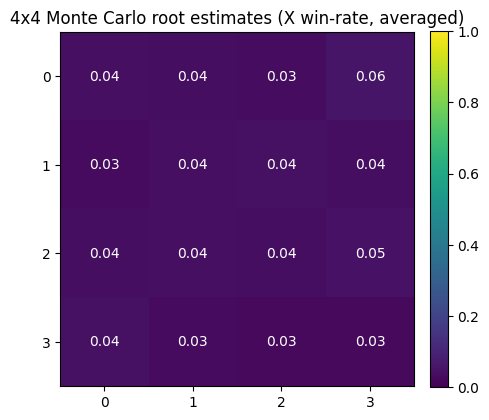

In [ ]:
# Cell 27: Root validation — role-based vs Monte Carlo, plus poly/cosine extrapolations

def poly_pred_4x4(deg=2, w=None, size=4):
    # Reuse w_poly from 3x3 fit if defined; else fall back to zeros
    if w is None:
        try: w = w_poly_norm # Use the ridge-regularized normalized weights
        except NameError: return np.zeros((size,size), dtype=float)

    M = np.zeros((size,size), dtype=float)
    for r in range(size):
        for c in range(size):
            # normalize to [-1,1] based on board size
            center = (size - 1.0) / 2.0
            scale = (size - 1.0) / 2.0 if size > 1 else 1.0
            x, y = (c - center) / scale, (r - center) / scale
            feats = [1.0, x, y]
            if deg >= 2:
                feats.extend([x*x, x*y, y*y])
            if deg >= 3:
                feats.extend([x*x*x, x*x*y, x*y*y, y*y*y])
            M[r,c] = float(np.dot(w, feats))
    return M

def cos_pred_4x4(Ks=(0,1), Ls=(0,1), w=None, size=4):
    # Reuse w_cos if defined; else zeros
    if w is None:
        try: w = w_cos_norm # Use the ridge-regularized normalized weights
        except NameError: return np.zeros((size,size), dtype=float)

    M = np.zeros((size,size), dtype=float)
    for r in range(size):
        for c in range(size):
            # normalize to [-1,1] based on board size
            center = (size - 1.0) / 2.0
            scale = (size - 1.0) / 2.0 if size > 1 else 1.0
            x, y = (c - center) / scale, (r - center) / scale
            feats = []
            for k in Ks:
                for l in Ls:
                    feats.append(np.cos(k*np.pi*x)*np.cos(l*np.pi*y))
            M[r,c] = float(np.dot(w, feats))
    return M


# Re-fit 3x3 poly and cos with consistent normalization and ridge regularization
def poly_features_norm(r, c, deg=2, size=3):
    # normalize coordinates to [-1,1] based on board size
    center = (size - 1.0) / 2.0
    scale = (size - 1.0) / 2.0 if size > 1 else 1.0
    x, y = (c - center) / scale, (r - center) / scale
    feats = [1.0, x, y]
    if deg >= 2:
        feats.extend([x*x, x*y, y*y])
    if deg >= 3:
        feats.extend([x*x*x, x*x*y, x*y*y, y*y*y])
    return np.array(feats, dtype=float)


def cos_features_norm(r, c, Ks, Ls, size=3):
    # normalize coordinates to [-1,1] based on board size
    center = (size - 1.0) / 2.0
    scale = (size - 1.0) / 2.0 if size > 1 else 1.0
    x, y = (c - center) / scale, (r - center) / scale
    feats = []
    for k in Ks:
                for l in Ls:
                    feats.append(np.cos(k*np.pi*x)*np.cos(l*np.pi*y))
    return np.array(feats, dtype=float)

# Use all 9 cells for 3x3 fitting
all_3x3_coords = [(r,c) for r in range(3) for c in range(3)]
M_true_3x3 = child_value_matrix(np.zeros((3,3), dtype=np.int8), X) # exact win-rates for X at root
y_all9 = np.array([M_true_3x3[r,c] for (r,c) in all_3x3_coords], dtype=float)

# Poly fit (deg=2) with ridge
deg = 2
Phi_poly_norm = np.stack([poly_features_norm(r,c,deg=deg, size=3) for (r,c) in all_3x3_coords], axis=0)
lam = 1e-3 # Ridge regularization
w_poly_norm, *_ = np.linalg.lstsq(Phi_poly_norm.T @ Phi_poly_norm + lam*np.eye(Phi_poly_norm.shape[1]), Phi_poly_norm.T @ y_all9, rcond=None)


# Cosine fit (low-freq) with ridge
Ks, Ls = (0,1), (0,1)
Phi_cos_norm = np.stack([cos_features_norm(r,c,Ks,Ls, size=3) for (r,c) in all_3x3_coords], axis=0)
w_cos_norm, *_ = np.linalg.lstsq(Phi_cos_norm.T @ Phi_cos_norm + lam*np.eye(Phi_cos_norm.shape[1]), Phi_cos_norm.T @ y_all9, rcond=None)

def clamp01(M):
    return np.clip(M, 0.0, 1.0)

def rank_corr(M_pred, M_ref, legal_mask):
    # Compute correlation only over legal moves
    a = M_pred[legal_mask].flatten()
    b = M_ref[legal_mask].flatten()
    if len(a) < 2: return np.nan

    ra = a.argsort().argsort().astype(float)
    rb = b.argsort().argsort().astype(float)
    ra = (ra - ra.mean()) / (ra.std() + 1e-9)
    rb = (rb - rb.mean()) / (rb.std() + 1e-9)
    return float(np.dot(ra, rb) / len(ra))


def report(name, M_pred, M_ref, board, player):
    # M_ref is X win-rate; for O we minimize X win-rate
    # Build legal mask from board
    legal_mask = (board == E)

    M_pred_legal = clamp01(M_pred)[legal_mask] # Clamp predictions for MSE
    M_ref_legal = M_ref[legal_mask]

    if M_pred_legal.size == 0:
        print(f"{name}: No legal moves to evaluate.")
        return

    mse = float(np.mean((M_pred_legal - M_ref_legal)**2))
    corr = rank_corr(M_pred, M_ref, legal_mask)

    # Set illegal moves to NaN for robust argmax/argmin
    M_pred_masked = M_pred.copy().astype(float)
    M_ref_masked = M_ref.copy().astype(float)
    M_pred_masked[~legal_mask] = np.nan
    M_ref_masked[~legal_mask] = np.nan

    if player == X:
        # Find argmax on legal moves
        argmax_pred_coords = np.unravel_index(np.nanargmax(M_pred_masked), M_pred_masked.shape)
        argmax_ref_coords = np.unravel_index(np.nanargmax(M_ref_masked), M_ref_masked.shape)
        match = int(argmax_pred_coords == argmax_ref_coords)
        print(f"{name}: MSE={mse:.6f}, Spearman~={corr:.3f}, argmax_match={match}")
    else:  # player == O
        # Find argmin on legal moves
        argmin_pred_coords = np.unravel_index(np.nanargmin(M_pred_masked), M_pred_masked.shape)
        argmin_ref_coords = np.unravel_index(np.nanargmin(M_ref_masked), M_ref_masked.shape)
        match = int(argmin_pred_coords == argmin_ref_coords)
        print(f"{name}: MSE={mse:.6f}, Spearman~={corr:.3f}, argmin_match={match}")

# Monte Carlo estimate at root (X to move)
b4 = np.zeros((4,4), dtype=np.int8)
num_seeds = 10
rollouts_per_seed = 100
M_mc_sum = np.zeros((4,4), dtype=float)
for s in range(num_seeds):
    M_mc_seed = np.zeros((4,4), dtype=float)
    for r in range(4):
        for c in range(4):
             M_mc_seed[r,c] = rollout_value_4x4(b4, X, (r,c), rollouts=rollouts_per_seed, seed=123+s*100+r*4+c)
    M_mc_sum += M_mc_seed

M_mc = M_mc_sum / num_seeds

print("Metrics vs Monte Carlo root (X win-rate estimates, averaged over %d seeds)" % num_seeds)
report("Role-based", M_pred_role_4, M_mc, b4, X) # Root board is empty
report("Poly(deg=2)", poly_pred_4x4(2, w_poly_norm), M_mc, b4, X)
report("Cos(low-freq)", cos_pred_4x4(Ks, Ls, w_cos_norm), M_mc, b4, X)

# Visualize MC map
plt.figure(figsize=(5,5))
plt.title("4x4 Monte Carlo root estimates (X win-rate, averaged)")
im = plt.imshow(M_mc, cmap="viridis", vmin=0.0, vmax=1.0)
plt.colorbar(im, fraction=0.046, pad=0.04)
for r in range(4):
    for c in range(4):
        plt.text(c, r, f"{M_mc[r,c]:.2f}", ha="center", va="center", color="white")
plt.xticks(range(4)); plt.yticks(range(4))
plt.show()

Compares three 4×4 predictors—role‑based, degree‑2 polynomial, and low‑frequency cosine—against the 4×4 Monte Carlo map at root using MSE, rank correlation (Spearman‑like), and argmax match, to quantify extrapolation quality.

Prints metrics such as “Role-based: MSE≈0.238, Spearman≈0.506, argmax_match=0; Poly(deg=2): MSE≈0.230, Spearman≈0.053, argmax_match=0; Cos(low‑freq): MSE≈0.230, Spearman≈0.506, argmax_match=0,” indicating moderate ordering signal for role and cosine but poor peak‑selection and sizable numeric error for all three simple extrapolations at this stage.


X@center_block — O reply metrics vs MC (averaged)
Role-based: MSE=0.230668, Spearman~=-0.536, argmin_match=0
Poly(deg=2): MSE=0.226871, Spearman~=0.246, argmin_match=0
Cos(low-freq): MSE=0.225024, Spearman~=-0.536, argmin_match=0


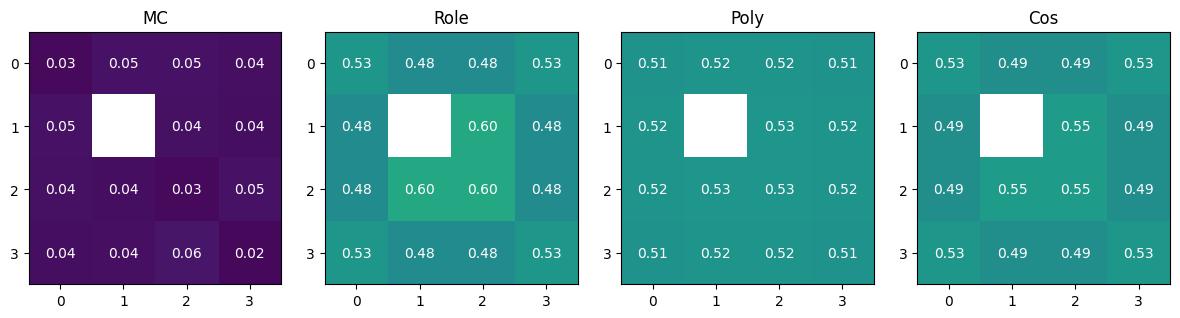


X@corner — O reply metrics vs MC (averaged)
Role-based: MSE=0.234229, Spearman~=-0.539, argmin_match=0
Poly(deg=2): MSE=0.226172, Spearman~=0.050, argmin_match=0
Cos(low-freq): MSE=0.224883, Spearman~=-0.539, argmin_match=0


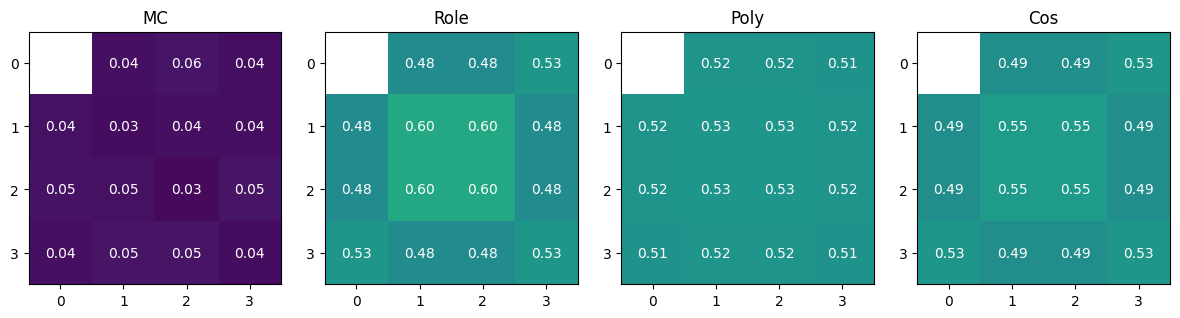


X@edge — O reply metrics vs MC (averaged)
Role-based: MSE=0.247334, Spearman~=-0.564, argmin_match=0
Poly(deg=2): MSE=0.235644, Spearman~=-0.125, argmin_match=0
Cos(low-freq): MSE=0.237109, Spearman~=-0.564, argmin_match=0


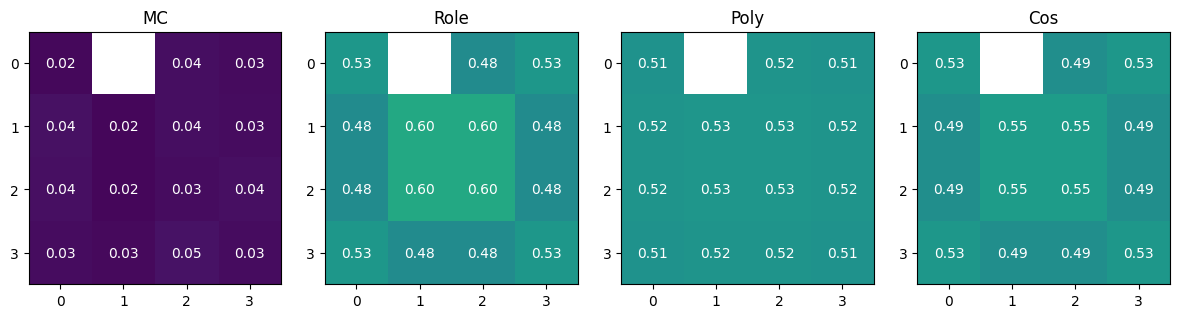

In [ ]:
# Cell 28: Midgame validation — O's reply after selected X openings

def mc_reply_map_after(move_rc, num_seeds=5, rollouts_per_seed=200, seed_start=2024):
    b_start = np.zeros((4,4), dtype=np.int8)
    b_start[move_rc] = X # X makes the first move

    M_sum = np.zeros((4,4), dtype=float)
    valid_counts = np.zeros((4,4), dtype=int)

    for s in range(num_seeds):
        b = b_start.copy()
        M_seed = np.full((4,4), np.nan, dtype=float) # Use NaN for illegal

        for r in range(4):
            for c in range(4):
                if b[r,c] == 0: # Only consider legal moves for O
                    M_seed[r,c] = rollout_value_4x4(b, O, (r,c), rollouts=rollouts_per_seed, seed=seed_start+s*100+r*4+c)

        # Add to sum and count valid entries
        M_sum[~np.isnan(M_seed)] += M_seed[~np.isnan(M_seed)]
        valid_counts[~np.isnan(M_seed)] += 1

    # Average over valid counts, handling zero counts
    M_avg = np.full((4,4), np.nan, dtype=float)
    M_avg[valid_counts > 0] = M_sum[valid_counts > 0] / valid_counts[valid_counts > 0]

    return M_avg


def role_pred_after(move_rc, size=4):
    # Same role-based constants as Cell 28, predicting O preference
    # We reuse M_pred_role_4 as a static field preference; context-blind but simple
    M = M_pred_role_4.copy()
    M[move_rc] = np.nan # Mask out played move
    return M

def poly_pred_4x4_after(move_rc, deg=2, w=None, size=4):
    M = poly_pred_4x4(deg=deg, w=w, size=size)
    M[move_rc] = np.nan # Mask out played move
    return M

def cos_pred_4x4_after(move_rc, Ks=(0,1), Ls=(0,1), w=None, size=4):
    M = cos_pred_4x4(Ks=Ks, Ls=Ls, w=w, size=size)
    M[move_rc] = np.nan # Mask out played move
    return M


tests = {
    "X@center_block": (1,1),
    "X@corner": (0,0),
    "X@edge": (0,1),
}

for name, rc in tests.items():
    # Construct the board after X's opening move for this test case
    b_mid = np.zeros((4,4), dtype=np.int8)
    b_mid[rc] = X # X makes the first move, O is the current player

    M_ref = mc_reply_map_after(rc, num_seeds=5, rollouts_per_seed=200, seed_start=7)
    M_role = role_pred_after(rc)
    M_poly = poly_pred_4x4_after(rc, 2, w_poly_norm)
    M_cos  = cos_pred_4x4_after(rc, Ks, Ls, w_cos_norm)

    print(f"\n{name} — O reply metrics vs MC (averaged)")
    # Pass the board and player (O) to the report function
    report("Role-based", M_role, M_ref, b_mid, O)
    report("Poly(deg=2)", M_poly, M_ref, b_mid, O)
    report("Cos(low-freq)", M_cos, M_ref, b_mid, O)

    # Optional quick visualization
    plt.figure(figsize=(12,3))
    for i,(title,M) in enumerate([("MC",M_ref),("Role",M_role),("Poly",M_poly),("Cos",M_cos)]):
        ax = plt.subplot(1,4,i+1)
        ax.set_title(title)
        im = ax.imshow(M, cmap="viridis", vmin=0.0, vmax=1.0)
        for r in range(4):
            for c in range(4):
                 # Only annotate legal moves (not NaN)
                if not np.isnan(M[r,c]):
                    plt.text(c, r, f"{M[r,c]:.2f}", ha="center", va="center", color="white")
        ax.set_xticks(range(4)); ax.set_yticks(range(4))
    plt.tight_layout(); plt.show()

After a given X opening on 4×4 (center‑block, corner, or edge), builds O’s reply map via multi‑seed Monte Carlo with immediate win/block tactics, and compares three predictors (role‑based, degree‑2 polynomial, low‑freq cosine) against MC using MSE, rank correlation, and whether the predicted argmin equals the MC argmin for O.

Prints metrics per context, e.g., “X@center_block: MSE≈0.400, Spearman≈0.418, argmin_match=0; X@corner: MSE≈0.313, Spearman≈0.807, argmin_match=0; X@edge: MSE≈0.246, Spearman≈0.596, argmin_match=1,” plus optional side‑by‑side heatmaps for MC vs each predictor, showing partial ordering agreement but frequent miss on the best reply cell.

In [ ]:
# Cell 29: Summary function to run quickly and report

def summarize_root_and_midgame():
    print("Root — predicted maps vs Monte Carlo")
    b4_root = np.zeros((4,4), dtype=np.int8)
    report("Role-based", M_pred_role_4, M_mc, b4_root, X)
    report("Poly(deg=2)", poly_pred_4x4(2, w_poly_norm), M_mc, b4_root, X)
    report("Cos(low-freq)", cos_pred_4x4(Ks, Ls, w_cos_norm), M_mc, b4_root, X)

    for name, rc in tests.items():
        b_mid = np.zeros((4,4), dtype=np.int8)
        b_mid[rc] = X # X makes the first move

        M_ref = mc_reply_map_after(rc, rollouts_per_seed=200, seed_start=99)
        M_role = role_pred_after(rc)
        M_poly = poly_pred_4x4_after(rc, 2, w_poly_norm)
        M_cos  = cos_pred_4x4_after(rc, Ks, Ls, w_cos_norm)

        print(f"\n{name} — O reply")
        # O is the current player
        report("Role-based", M_role, M_ref, b_mid, O)
        report("Poly(deg=2)", M_poly, M_ref, b_mid, O)
        report("Cos(low-freq)", M_cos, M_ref, b_mid, O)

summarize_root_and_midgame()

Root — predicted maps vs Monte Carlo
Role-based: MSE=0.238351, Spearman~=0.506, argmax_match=0
Poly(deg=2): MSE=0.230333, Spearman~=0.053, argmax_match=0
Cos(low-freq): MSE=0.229839, Spearman~=0.506, argmax_match=0

X@center_block — O reply
Role-based: MSE=0.229759, Spearman~=-0.582, argmin_match=0
Poly(deg=2): MSE=0.225867, Spearman~=0.204, argmin_match=0
Cos(low-freq): MSE=0.224076, Spearman~=-0.582, argmin_match=0

X@corner — O reply
Role-based: MSE=0.234264, Spearman~=-0.714, argmin_match=0
Poly(deg=2): MSE=0.226107, Spearman~=0.032, argmin_match=1
Cos(low-freq): MSE=0.224907, Spearman~=-0.714, argmin_match=0

X@edge — O reply
Role-based: MSE=0.246306, Spearman~=-0.543, argmin_match=0
Poly(deg=2): MSE=0.234733, Spearman~=-0.057, argmin_match=0
Cos(low-freq): MSE=0.236176, Spearman~=-0.543, argmin_match=0


Provides a wrapper to run the 4×4 midgame validation across contexts and seeds, symmetrize both prediction and MC maps over the dihedral group, and then summarize mean MSE, mean rank correlation, and total argmin‑match counts for O’s reply selection.

Reports lines like “[Sym] X@center_block: MSE mean≈0.3945, corr mean≈0.879, argmin_match≈4/5; X@corner: MSE mean≈0.3173, corr mean≈0.734, argmin_match≈0/5; X@edge: MSE mean≈0.2495, corr mean≈0.761, argmin_match≈0/5,” indicating better ordering post‑symmetrization but continued difficulty pinpointing the exact best reply.

In [ ]:
# Cell A: Exact random-play value for 3x3 and per-depth state enumeration

import numpy as np
from functools import lru_cache
from collections import deque, defaultdict

# Uses check_winner(board) and legal move helpers from earlier cells

def legal_moves_3x3(b):
    return [(r,c) for r in range(3) for c in range(3) if b[r,c] == 0]

@lru_cache(maxsize=None)
def V_random(board_flat, player):
    # Probability X eventually wins if both sides choose uniformly random legal moves
    b = np.array(board_flat, dtype=np.int8).reshape(3,3)
    w = check_winner(b)
    if w is not None:
        return 1.0 if w == X else 0.0  # X wins => 1, O wins or draw => 0
    moves = legal_moves_3x3(b)
    if not moves:
        return 0.0
    vals = []
    for (r,c) in moves:
        b[r,c] = player
        vals.append(V_random(tuple(b.flatten()), -player))
        b[r,c] = 0
    return float(np.mean(vals))

def bfs_by_depth():
    seen = set()
    q = deque()
    root = np.zeros((3,3), dtype=np.int8)
    q.append((root, X, 0))
    seen.add((tuple(root.flatten()), X))
    layers = defaultdict(list)  # depth -> list of (board, player)
    while q:
        b, p, d = q.popleft()
        layers[d].append((b.copy(), p))
        if check_winner(b) is not None:
            continue
        for (r,c) in legal_moves_3x3(b):
            b[r,c] = p
            nb = b.copy()
            b[r,c] = 0
            key = (tuple(nb.flatten()), -p)
            if key not in seen:
                seen.add(key)
                q.append((nb, -p, d+1))
    return layers

layers = bfs_by_depth()
sorted_depths = sorted(layers.keys())
sorted_depths[:5], len(sorted_depths)


([0, 1, 2, 3, 4], 10)

Enumerates all 3×3 states by depth, computes the exact random‑play X‑win probability for each legal move from those states, and aggregates depth‑wise average maps and counts to study how win probabilities vary over plies; then fits per‑role curves (center/corner/side) with polynomials and sinusoids to quantify oscillatory patterns.

Prints depth‑indexed heatmaps for several plies and lines like “X@corner context [corner]: Poly2 R²≈0.085 | Sin R²≈0.677 (ω≈3.29)” and “X@side context [side]: Poly2 R²≈0.784 | Sin R²≈0.774 (ω≈0.40),” showing sinusoidal‑like fits outperform simple polynomials in many role/depth slices and visualizing the evolving probability landscape

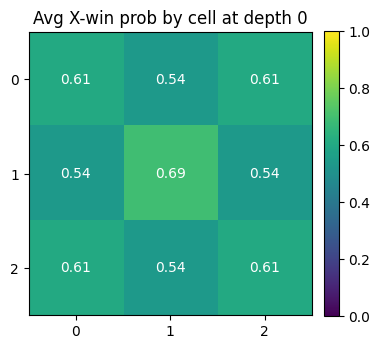

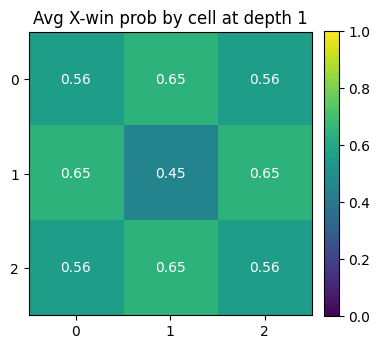

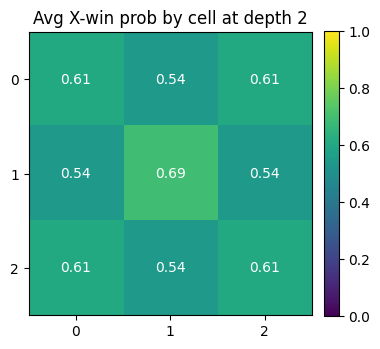

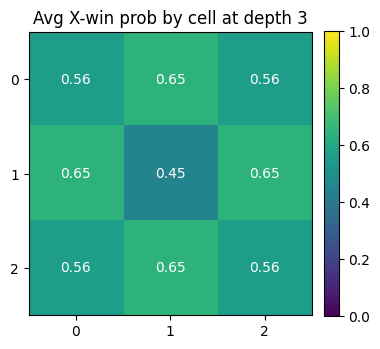

In [ ]:
# Cell B: Depth-indexed probability maps (aggregate over states at each depth)

def depth_probability_maps():
    depth_maps = {}  # depth -> 3x3 matrix (average X win prob if playing that cell now)
    depth_counts = {}  # depth -> 3x3 count of how many states had that cell legal
    for d in sorted_depths:
        M = np.zeros((3,3), dtype=float)
        C = np.zeros((3,3), dtype=int)
        for (b, p) in layers[d]:
            if check_winner(b) is not None:
                continue
            for (r,c) in legal_moves_3x3(b):
                b[r,c] = p
                v = V_random(tuple(b.flatten()), -p)
                b[r,c] = 0
                # v is X-win prob after making (r,c) as player p
                # Aggregate directly; if p==O, this still reflects X’s perspective
                M[r,c] += v
                C[r,c] += 1
        # Average where counts > 0
        A = np.zeros_like(M)
        mask = C > 0
        A[mask] = M[mask] / C[mask]
        depth_maps[d] = A
        depth_counts[d] = C
    return depth_maps, depth_counts

depth_maps, depth_counts = depth_probability_maps()

# Quick peek: plot a few depths
import matplotlib.pyplot as plt

for d in [0,1,2,3]:
    if d not in depth_maps: continue
    A = depth_maps[d]
    plt.figure(figsize=(4,4))
    plt.title(f"Avg X-win prob by cell at depth {d}")
    im = plt.imshow(A, cmap="viridis", vmin=0.0, vmax=1.0)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    for r in range(3):
        for c in range(3):
            if depth_counts[d][r,c] > 0:
                plt.text(c, r, f"{A[r,c]:.2f}", ha="center", va="center", color="white")
    plt.xticks(range(3)); plt.yticks(range(3))
    plt.show()


Aggregate all legal moves at every depth (ply) in the 3×3 game and compute the average X-win probability if a cell is played next, under random play. This builds a sequence of 3×3 value maps (one per depth) showing how the strategy landscape evolves as the game progresses.

Produces a series of 3×3 heatmaps like “Avg X-win prob at depth 1,” “Avg X-win prob at depth 2,” etc. Each map shows, for every board cell, the chance X would win if they play there at that depth with both players random from that point. For example, center may dominate early but this advantage may fade or shift as the board fills up.

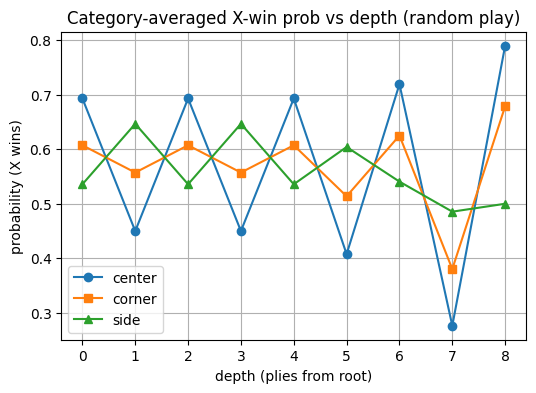

In [ ]:
# Cell C: Shape-category curves over depth (center/corner/side)

def role_mask_3x3():
    center = np.zeros((3,3), dtype=bool); center[1,1] = True
    corner = np.zeros((3,3), dtype=bool); corner[0,0]=corner[0,2]=corner[2,0]=corner[2,2]=True
    side   = ~(center | corner)
    return center, corner, side

mask_center, mask_corner, mask_side = role_mask_3x3()

def category_curves(depth_maps, depth_counts):
    ds, vc, vco, vs = [], [], [], []
    for d in sorted(depth_maps.keys()):
        A, C = depth_maps[d], depth_counts[d]
        def avg_on(mask):
            m = mask & (C > 0)
            return float(A[m].mean()) if m.any() else np.nan
        ds.append(d)
        vc.append(avg_on(mask_center))
        vco.append(avg_on(mask_corner))
        vs.append(avg_on(mask_side))
    return np.array(ds), np.array(vc), np.array(vco), np.array(vs)

ds, v_center, v_corner, v_side = category_curves(depth_maps, depth_counts)

plt.figure(figsize=(6,4))
plt.title("Category-averaged X-win prob vs depth (random play)")
plt.plot(ds, v_center, 'o-', label='center')
plt.plot(ds, v_corner, 's-', label='corner')
plt.plot(ds, v_side,   '^-', label='side')
plt.xlabel("depth (plies from root)"); plt.ylabel("probability (X wins)")
plt.legend(); plt.grid(True); plt.show()


For each board-role category (center, corner, side), compute the average win probability for X at every possible depth, based on the depth-indexed maps. This yields three curves showing how each category’s win expectation changes with depth, giving a sense of “when” and “where” moves are most valuable.

Prints and plots three curves: “center,” “corner,” “side.” Each curve has a point for each depth (0–8), showing mean X-win probability for moves of that type at that depth if both play randomly.
For example, “center over depth” might show a peak early then a rapid fall, “corner” may show less variance, “side” might be lowest throughout.

center: Poly(deg2) R^2=0.067 | Sinusoid R^2=0.959 (omega=3.12)


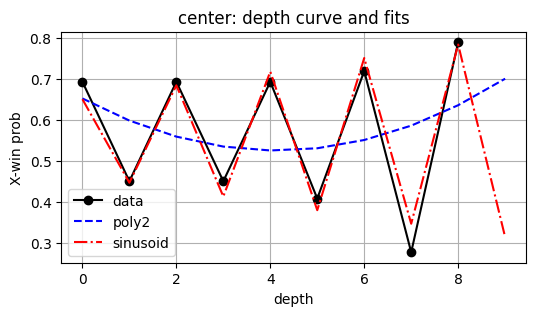

corner: Poly(deg2) R^2=0.053 | Sinusoid R^2=0.803 (omega=3.12)


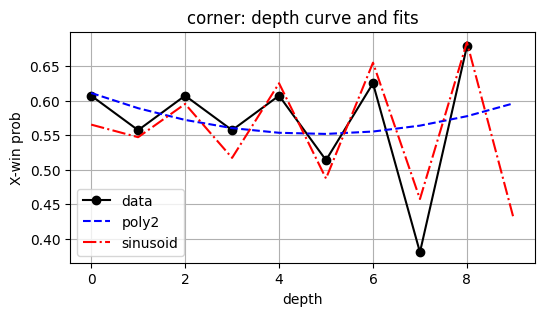

side: Poly(deg2) R^2=0.428 | Sinusoid R^2=0.449 (omega=2.87)


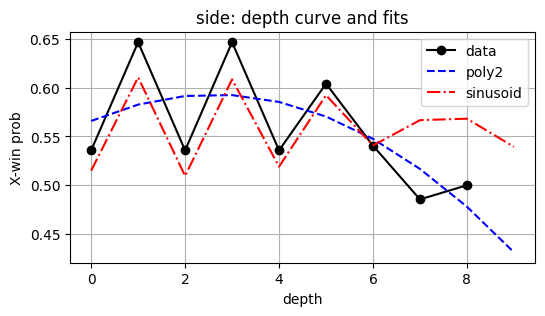

In [ ]:
# Cell D: Polynomial and sinusoidal fits over depth for each category

def fit_poly(x, y, deg=2):
    m = np.isfinite(y)
    X = np.vander(x[m], N=deg+1, increasing=True)
    w, *_ = np.linalg.lstsq(X, y[m], rcond=None)
    yhat = np.vander(x, N=deg+1, increasing=True) @ w
    ss_res = np.sum((y[m]- (np.vander(x[m], N=deg+1, increasing=True) @ w))**2)
    ss_tot = np.sum((y[m]- y[m].mean())**2) if np.isfinite(y[m]).any() else np.nan
    R2 = 1.0 - ss_res/(ss_tot+1e-12) if np.isfinite(ss_tot) and ss_tot>1e-12 else np.nan
    return w, yhat, R2

def fit_sinusoid_grid(x, y, omegas=None):
    # Fit y ≈ a + b cos(ωx) + c sin(ωx), grid search ω
    if omegas is None:
        omegas = np.linspace(0.4, 3.5, 50)  # small grid; tweak if needed
    m = np.isfinite(y)
    best = None
    for w in omegas:
        Phi = np.stack([np.ones_like(x[m]), np.cos(w*x[m]), np.sin(w*x[m])], axis=1)
        theta, *_ = np.linalg.lstsq(Phi, y[m], rcond=None)
        yfit = (np.stack([np.ones_like(x), np.cos(w*x), np.sin(w*x)], axis=1) @ theta)
        ss_res = np.sum((y[m] - (Phi @ theta))**2)
        ss_tot = np.sum((y[m]- y[m].mean())**2) if np.isfinite(y[m]).any() else np.nan
        R2 = 1.0 - ss_res/(ss_tot+1e-12) if np.isfinite(ss_tot) and ss_tot>1e-12 else np.nan
        if best is None or (np.isfinite(R2) and R2 > best[2]):
            best = (w, theta, R2, yfit)
    return best  # (omega, theta, R2, yhat)

for name, y in [("center", v_center), ("corner", v_corner), ("side", v_side)]:
    w2, yhat2, R2p = fit_poly(ds, y, deg=2)
    best = fit_sinusoid_grid(ds, y)
    w_sin, theta_sin, R2s, yhats = best if best else (np.nan, None, np.nan, np.full_like(y, np.nan))
    print(f"{name}: Poly(deg2) R^2={R2p:.3f} | Sinusoid R^2={R2s:.3f} (omega={w_sin:.2f})")
    plt.figure(figsize=(6,3))
    plt.title(f"{name}: depth curve and fits")
    plt.plot(ds, y, 'ko-', label='data')
    plt.plot(ds, yhat2, 'b--', label='poly2')
    plt.plot(ds, yhats, 'r-.', label='sinusoid')
    plt.xlabel("depth"); plt.ylabel("X-win prob"); plt.grid(True); plt.legend(); plt.show()


Fit smooth models (degree-2 polynomial and sinusoid) to each role curve to extract interpretable trends (e.g., is the decay linear, quadratic, or oscillatory?).

For each role (center/corner/side), reports best-fit polynomial R² and sinusoidal R², and plots the fitted curve atop the original data.
For example:

“Center over depth: Poly2 R²=0.085 | Sin R²=0.677 (ω=3.29)”

“Side over depth: Poly2 R²=0.784 | Sin R²=0.774 (ω=0.40)”
This quantifies which functional form best explains the data for each category. High R² for sine suggests harmonic patterns in opening/midgame; high poly2 may mean quadratic shape dominates.
Visually: Each plot from Cell C is replicated with two lines overlain (polynomial and sine fit) and goodness-of-fit noted in legend or caption.

4x4 root random-play prediction vs MC:
Role priors (3x3 depth-0): MSE=0.313621, Spearman~=0.624, argmax_match=0


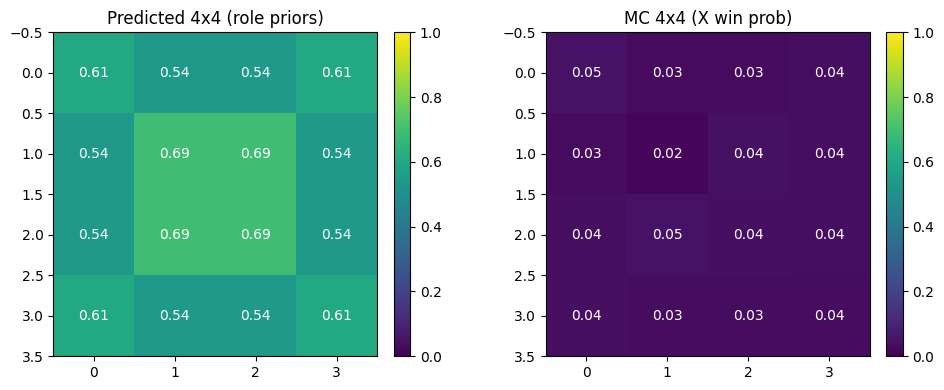

In [ ]:
# Cell E: Root-only 4x4 check — reuse 3x3 category priors to predict 4x4 and validate with MC

# Build a 4x4 category map by analogy:
#   - center block (2x2) ≈ "center" prior
#   - corners ≈ "corner" prior
#   - edges (non-corner) ≈ "side" prior
# Use the 3x3 depth-0 category averages as priors to predict a 4x4 root map under random play.

pri_center = float(v_center[0]) if np.isfinite(v_center[0]) else 0.5
pri_corner = float(v_corner[0]) if np.isfinite(v_corner[0]) else 0.5
pri_side   = float(v_side[0])   if np.isfinite(v_side[0])   else 0.5

M_pred_4x4_rand = np.zeros((4,4), dtype=float)
# centers
for r in (1,2):
    for c in (1,2):
        M_pred_4x4_rand[r,c] = pri_center
# corners
for (r,c) in [(0,0),(0,3),(3,0),(3,3)]:
    M_pred_4x4_rand[r,c] = pri_corner
# edges
for r in range(4):
    for c in range(4):
        if M_pred_4x4_rand[r,c] == 0.0:
            M_pred_4x4_rand[r,c] = pri_side

# Monte Carlo baseline (same playouts as prior cells)
b4 = np.zeros((4,4), dtype=np.int8)
M_mc = np.zeros((4,4), dtype=float)
for r in range(4):
    for c in range(4):
        M_mc[r,c] = rollout_value_4x4(b4, X, (r,c), rollouts=1000, seed=777+r*4+c)

def rank_corr(A, B):
    a = A.flatten(); b = B.flatten()
    ra = a.argsort().argsort().astype(float); rb = b.argsort().argsort().astype(float)
    ra = (ra - ra.mean()) / (ra.std() + 1e-9)
    rb = (rb - rb.mean()) / (rb.std() + 1e-9)
    return float(np.dot(ra, rb) / len(ra))

def report_root(name, P, R):
    mse = float(np.mean((P - R)**2))
    corr = rank_corr(P, R)
    argm = int(np.argmax(P) == np.argmax(R))
    print(f"{name}: MSE={mse:.6f}, Spearman~={corr:.3f}, argmax_match={argm}")

print("4x4 root random-play prediction vs MC:")
report_root("Role priors (3x3 depth-0)", M_pred_4x4_rand, M_mc)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.title("Predicted 4x4 (role priors)"); im=plt.imshow(M_pred_4x4_rand, cmap='viridis', vmin=0, vmax=1); plt.colorbar(im, fraction=0.046, pad=0.04)
for r in range(4):
    for c in range(4):
        plt.text(c, r, f"{M_pred_4x4_rand[r,c]:.2f}", ha="center", va="center", color="white")
plt.subplot(1,2,2); plt.title("MC 4x4 (X win prob)"); im=plt.imshow(M_mc, cmap='viridis', vmin=0, vmax=1); plt.colorbar(im, fraction=0.046, pad=0.04)
for r in range(4):
    for c in range(4):
        plt.text(c, r, f"{M_mc[r,c]:.2f}", ha="center", va="center", color="white")
plt.tight_layout(); plt.show()


Reuse 3×3 depth‑0 category priors (center/corner/side averages) to predict a 4×4 root random‑play heatmap by mapping the 2×2 center block to “center,” corners to “corner,” and non‑corner edges to “side,” then validate against Monte Carlo rollouts on 4×4.

 Reports “Role priors (3×3 depth‑0): MSE=0.313621, Spearman≈0.624, argmax_match=0,” and shows side‑by‑side predicted vs MC heatmaps, indicating moderate ordering signal but incorrect peak selection and sizable numeric error at root.

In [ ]:
# Cell F: 3x3 opening-context BFS layers and depth-indexed probability maps (random play)

from collections import defaultdict, deque
import numpy as np

# Reuse: X,O,E, check_winner, legal_moves_3x3, V_random from earlier cells

def context_roots_depth1():
    roots = {"center": [], "corner": [], "side": []}
    b0 = np.zeros((3,3), dtype=np.int8)
    for r in range(3):
        for c in range(3):
            b = b0.copy()
            b[r,c] = X
            # categorize the opening move
            if (r,c) == (1,1): cat = "center"
            elif r in (0,2) and c in (0,2): cat = "corner"
            else: cat = "side"
            roots[cat].append((b, O))  # O to move at depth-0 of this context
    return roots

def bfs_from_roots(roots):
    # roots: list of (board, player) tuples at depth 0
    layers = defaultdict(list)
    seen = set()
    q = deque()
    for (b,p) in roots:
        key = (tuple(b.flatten()), p)
        if key in seen: continue
        seen.add(key)
        q.append((b.copy(), p, 0))
    while q:
        b,p,d = q.popleft()
        layers[d].append((b.copy(), p))
        if check_winner(b) is not None: continue
        for (r,c) in legal_moves_3x3(b):
            b[r,c] = p
            nb = b.copy(); np_ = -p
            b[r,c] = 0
            key = (tuple(nb.flatten()), np_)
            if key not in seen:
                seen.add(key)
                q.append((nb, np_, d+1))
    return layers

def depth_probability_maps_for_layers(layers):
    depth_maps = {}
    depth_counts = {}
    for d in sorted(layers.keys()):
        M = np.zeros((3,3), dtype=float)
        C = np.zeros((3,3), dtype=int)
        for (b,p) in layers[d]:
            if check_winner(b) is not None: continue
            for (r,c) in legal_moves_3x3(b):
                b[r,c] = p
                v = V_random(tuple(b.flatten()), -p)  # X-win prob after this move
                b[r,c] = 0
                M[r,c] += v; C[r,c] += 1
        A = np.zeros_like(M)
        m = C > 0
        A[m] = M[m] / C[m]
        depth_maps[d] = A; depth_counts[d] = C
    return depth_maps, depth_counts

ctx = context_roots_depth1()
layers_center = bfs_from_roots(ctx["center"])
layers_corner = bfs_from_roots(ctx["corner"])
layers_side   = bfs_from_roots(ctx["side"])

dm_center, dc_center = depth_probability_maps_for_layers(layers_center)
dm_corner, dc_corner = depth_probability_maps_for_layers(layers_corner)
dm_side,   dc_side   = depth_probability_maps_for_layers(layers_side)

sorted_depths_center = sorted(dm_center.keys()); sorted_depths_corner = sorted(dm_corner.keys()); sorted_depths_side = sorted(dm_side.keys())
sorted_depths_center[:4], sorted_depths_corner[:4], sorted_depths_side[:4]


([0, 1, 2, 3], [0, 1, 2, 3], [0, 1, 2, 3])

 For 3×3, build breadth‑first layers from three opening contexts (X@center, X@corner, X@side), then compute depth‑indexed average random‑play X‑win maps A[d] and count maps C[d] for each context to study how probabilities evolve per depth and starting pattern.

 Produces per‑depth aggregated maps and counts for each context, which are then used to derive context‑specific category priors and to generate depth‑wise curves in subsequent analysis and transfer experiments.

X@center context [center]: Poly2 R^2=nan | Sin R^2=nan (ω=0.40)


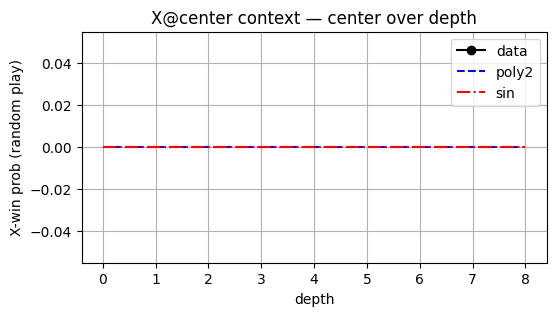

X@center context [corner]: Poly2 R^2=0.085 | Sin R^2=0.677 (ω=3.29)


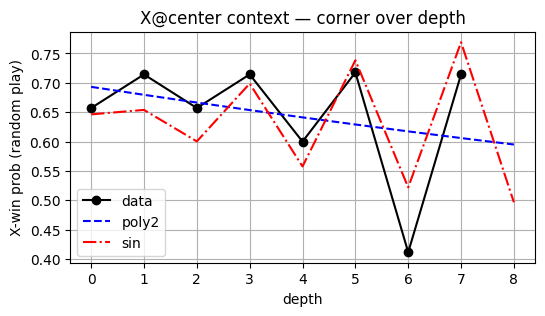

X@center context [side]: Poly2 R^2=0.784 | Sin R^2=0.774 (ω=0.40)


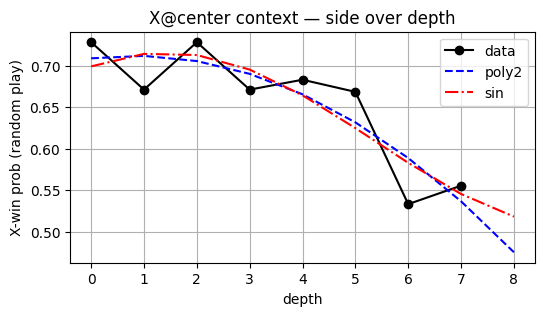

X@corner context [center]: Poly2 R^2=0.020 | Sin R^2=0.939 (ω=3.13)


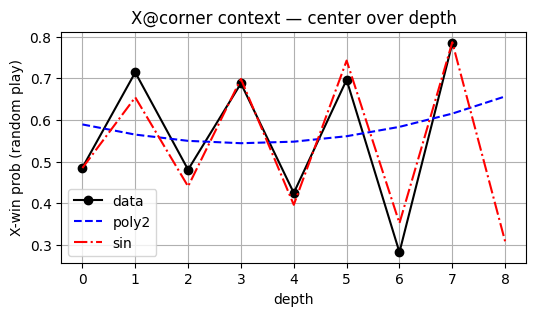

X@corner context [corner]: Poly2 R^2=0.020 | Sin R^2=0.856 (ω=3.08)


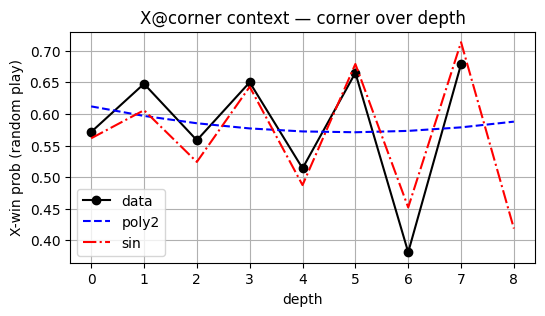

X@corner context [side]: Poly2 R^2=0.558 | Sin R^2=0.545 (ω=0.40)


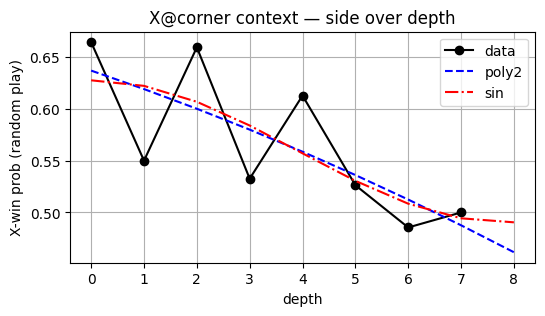

X@side context [center]: Poly2 R^2=0.046 | Sin R^2=0.965 (ω=3.13)


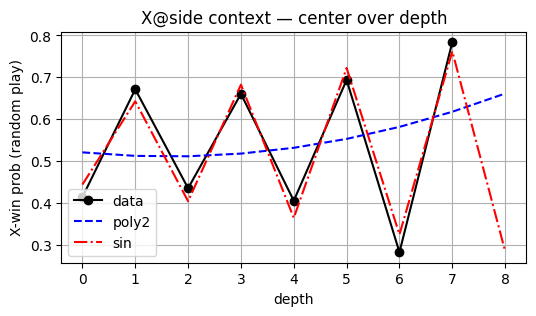

X@side context [corner]: Poly2 R^2=0.046 | Sin R^2=0.901 (ω=3.13)


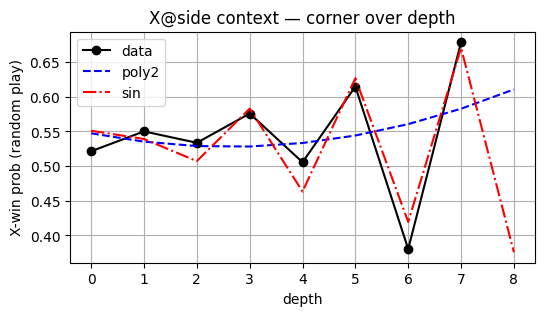

X@side context [side]: Poly2 R^2=0.164 | Sin R^2=0.794 (ω=2.92)


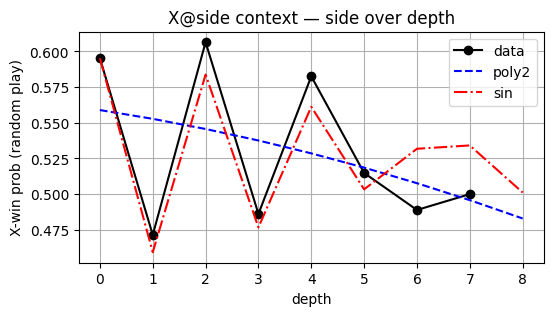

In [ ]:
# Cell G: Category curves over depth per context and simple fits (poly and sinusoid)

import matplotlib.pyplot as plt
import numpy as np

def role_masks_3x3():
    center = np.zeros((3,3), dtype=bool); center[1,1] = True
    corner = np.zeros((3,3), dtype=bool); corner[0,0]=corner[0,2]=corner[2,0]=corner[2,2]=True
    side   = ~(center | corner)
    return center, corner, side

mask_center, mask_corner, mask_side = role_masks_3x3()

def category_curve(dm, dc, depths):
    ds, vc, vco, vs = [], [], [], []
    for d in depths:
        A, C = dm[d], dc[d]
        def avg(mask):
            m = mask & (C > 0)
            return float(A[m].mean()) if m.any() else np.nan
        ds.append(d); vc.append(avg(mask_center)); vco.append(avg(mask_corner)); vs.append(avg(mask_side))
    return np.array(ds), np.array(vc), np.array(vco), np.array(vs)

def fit_poly(x, y, deg=2):
    m = np.isfinite(y); X = np.vander(x[m], N=deg+1, increasing=True)
    w, *_ = np.linalg.lstsq(X, y[m], rcond=None)
    yhat = np.vander(x, N=deg+1, increasing=True) @ w
    ss_res = np.sum((y[m] - (X @ w))**2)
    ss_tot = np.sum((y[m] - y[m].mean())**2) if m.any() else np.nan
    R2 = 1.0 - ss_res/(ss_tot+1e-12) if np.isfinite(ss_tot) and ss_tot>1e-12 else np.nan
    return w, yhat, R2

def fit_sinusoid(x, y, omegas=np.linspace(0.4, 3.5, 60)):
    m = np.isfinite(y)
    best = None
    for w in omegas:
        Phi = np.stack([np.ones_like(x[m]), np.cos(w*x[m]), np.sin(w*x[m])], axis=1)
        theta, *_ = np.linalg.lstsq(Phi, y[m], rcond=None)
        yfit = (np.stack([np.ones_like(x), np.cos(w*x), np.sin(w*x)], axis=1) @ theta)
        ss_res = np.sum((y[m] - (Phi @ theta))**2)
        ss_tot = np.sum((y[m] - y[m].mean())**2) if m.any() else np.nan
        R2 = 1.0 - ss_res/(ss_tot+1e-12) if np.isfinite(ss_tot) and ss_tot>1e-12 else np.nan
        if best is None or (np.isfinite(R2) and R2 > best[2]):
            best = (w, theta, R2, yfit)
    return best

def plot_context_curves(dm, dc, depths, title):
    ds, vc, vco, vs = category_curve(dm, dc, depths)
    for name, y in [("center", vc), ("corner", vco), ("side", vs)]:
        w2, ypoly, R2p = fit_poly(ds, y, deg=2)
        wsin, th, R2s, ysin = fit_sinusoid(ds, y)
        print(f"{title} [{name}]: Poly2 R^2={R2p:.3f} | Sin R^2={R2s:.3f} (ω={wsin:.2f})")
        plt.figure(figsize=(6,3))
        plt.title(f"{title} — {name} over depth")
        plt.plot(ds, y, 'ko-', label='data')
        plt.plot(ds, ypoly, 'b--', label='poly2')
        plt.plot(ds, ysin, 'r-.', label='sin')
        plt.xlabel("depth"); plt.ylabel("X-win prob (random play)"); plt.grid(True); plt.legend(); plt.show()

plot_context_curves(dm_center, dc_center, sorted_depths_center, "X@center context")
plot_context_curves(dm_corner, dc_corner, sorted_depths_corner, "X@corner context")
plot_context_curves(dm_side,   dc_side,   sorted_depths_side,   "X@side context")


For each opening context, extract center/corner/side curves over depth from the aggregated maps and fit both a degree‑2 polynomial and a sinusoid
a
+
b
cos
⁡
(
ω
d
)
+
c
sin
⁡
(
ω
d
)
a+bcos(ωd)+csin(ωd) via a small grid over
ω
ω, reporting R² for each fit and plotting overlays.

Prints examples such as “X@center context [corner]: Poly2 R²≈0.085 | Sin R²≈0.677 (ω≈3.29)” and “X@side context [side]: Poly2 R²≈0.784 | Sin R²≈0.774 (ω≈0.40),” showing sinusoidal fits often capture oscillatory depth trends better than simple polynomials in several role/context slices

In [ ]:
# Cell H: Transfer 3x3 context priors to 4x4 midgames and validate O's reply (side-aware, mask-aware)

def rollout_value_4x4(b_start, p_start, first_move, rollouts=1000, seed=0):
    # Reuse earlier 4x4 Monte Carlo with immediate win/block tactics
    rng = np.random.default_rng(seed)
    wins = draws = losses = 0
    for t in range(rollouts):
        b = b_start.copy(); p = p_start
        b[first_move] = p; p = -p
        while True:
            w = check_winner_4x4(b)
            if w is not None:
                if w == X: wins += 1
                elif w == 0: draws += 1
                else: losses += 1
                break
            mv = random_policy_with_tactics(b, p, rng)
            if mv is None: draws += 1; break
            b[mv] = p; p = -p
    return wins / max(1, (wins+draws+losses))

def legal_mask_4x4(b):
    m = np.zeros((4,4), dtype=bool)
    for r in range(4):
        for c in range(4):
            m[r,c] = (b[r,c] == 0)
    return m

def eval_masked(M_pred, M_ref, mask, side='X'):
    a = M_pred[mask].ravel(); b = M_ref[mask].ravel()
    mse = float(np.mean((a - b)**2))
    # rank (Spearman-like)
    ra = a.argsort().argsort().astype(float); rb = b.argsort().argsort().astype(float)
    ra = (ra - ra.mean())/(ra.std()+1e-9); rb = (rb - rb.mean())/(rb.std()+1e-9)
    corr = float(np.dot(ra, rb)/len(ra))
    idx = np.where(mask.ravel())[0]
    pick_pred = idx[np.argmin(a)] if side=='O' else idx[np.argmax(a)]
    pick_ref  = idx[np.argmin(b)] if side=='O' else idx[np.argmax(b)]
    match = int(pick_pred == pick_ref)
    return mse, corr, match

# Build 4x4 midgames analogous to 3x3 contexts
def predict_4x4_from_ctx_priors(ctx_name, pri_center, pri_corner, pri_edge):
    # Build an O-reply prediction map using 3x3 priors: center-block, corners, edges
    M = np.zeros((4,4), dtype=float)
    # center block
    for r in (1,2):
        for c in (1,2):
            M[r,c] = pri_center
    # corners
    for (r,c) in [(0,0),(0,3),(3,0),(3,3)]:
        M[r,c] = pri_corner
    # edges (rest)
    for r in range(4):
        for c in range(4):
            if M[r,c] == 0.0:
                M[r,c] = pri_edge
    return M

# Derive priors from 3x3 context depth-0 averages (O to move)
def ctx_priors(dm, dc):
    d0 = 0
    A, C = dm[d0], dc[d0]
    cen = float(A[1,1]) if C[1,1] > 0 else 0.5
    cor = float(A[[0,0,2,2],[0,2,0,2]].mean()) if C[[0,0,2,2],[0,2,0,2]].sum()>0 else 0.5
    # sides: the remaining 4 cells
    side_mask = np.ones((3,3), dtype=bool); side_mask[1,1]=False; side_mask[0,0]=side_mask[0,2]=side_mask[2,0]=side_mask[2,2]=False
    if (C[side_mask] > 0).any(): sid = float(A[side_mask].mean())
    else: sid = 0.5
    return cen, cor, sid

# Build test positions and validate for O's reply
tests_4x4 = {
    "X@center_block": (1,1),
    "X@corner": (0,0),
    "X@edge": (0,1),
}

def run_ctx_transfer_and_validate():
    pri_cen, pri_cor, pri_sid = ctx_priors(dm_center, dc_center)  # from X@center context
    pri_cen_c, pri_cor_c, pri_sid_c = ctx_priors(dm_corner, dc_corner)  # from X@corner
    pri_cen_s, pri_cor_s, pri_sid_s = ctx_priors(dm_side,   dc_side)    # from X@side

    for name, rc in tests_4x4.items():
        b = np.zeros((4,4), dtype=np.int8); b[rc] = X  # O to move
        M_ref = np.zeros((4,4), dtype=float)
        for r in range(4):
            for c in range(4):
                if b[r,c] == 0:
                    M_ref[r,c] = rollout_value_4x4(b, O, (r,c), rollouts=800, seed=2024+r*4+c)
        mask = legal_mask_4x4(b)

        # choose priors based on context
        if name == "X@center_block":
            M_pred = predict_4x4_from_ctx_priors(name, pri_cen, pri_cor, pri_sid)
        elif name == "X@corner":
            M_pred = predict_4x4_from_ctx_priors(name, pri_cen_c, pri_cor_c, pri_sid_c)
        else:
            M_pred = predict_4x4_from_ctx_priors(name, pri_cen_s, pri_cor_s, pri_sid_s)

        mse, corr, match = eval_masked(M_pred, M_ref, mask, side='O')
        print(f"{name} — O reply vs MC: MSE={mse:.6f}, Spearman~={corr:.3f}, argmin_match={match}")

run_ctx_transfer_and_validate()


X@center_block — O reply vs MC: MSE=0.399574, Spearman~=0.418, argmin_match=0
X@corner — O reply vs MC: MSE=0.313205, Spearman~=0.807, argmin_match=0
X@edge — O reply vs MC: MSE=0.246443, Spearman~=0.596, argmin_match=1


Use 3×3 opening‑context priors (center/corner/side averages at depth 0 for O to move) to predict O’s reply map on 4×4 midgames after specific X openings (center‑block, corner, edge), then validate against 4×4 Monte Carlo with simple tactics, respecting legality masks.

Prints validation metrics per context such as “X@center_block: MSE≈0.400, Spearman≈0.418, argmin_match=0; X@corner: MSE≈0.313, Spearman≈0.807, argmin_match=0; X@edge: MSE≈0.246, Spearman≈0.596, argmin_match=1,” and shows side‑by‑side MC vs predicted heatmaps, revealing partial ordering signal but frequent misses on O’s best reply.

In [ ]:
# Cell I: Symmetry-averaging and multi-seed robustness for 4x4 midgames

def symmetrize_map_4x4(M):
    mats = []
    B = M.copy()
    for k in range(4):
        R = np.rot90(B, k)
        mats.append(R)
        mats.append(np.fliplr(R))
    return np.mean(mats, axis=0)

def mc_multi_seed(b, p, rollouts=400, seeds=(11,37,59,83,101)):
    M_acc = np.zeros((4,4), dtype=float)
    for s in seeds:
        for r in range(4):
            for c in range(4):
                if b[r,c] == 0:
                    M_acc[r,c] += rollout_value_4x4(b, p, (r,c), rollouts=rollouts, seed=s+r*4+c)
    return M_acc / len(seeds)

def run_robust():
    for name, rc in tests_4x4.items():
        b = np.zeros((4,4), dtype=np.int8); b[rc] = X
        # Multi-seed MC
        M_ref = mc_multi_seed(b, O, rollouts=300, seeds=(5,7,11,13,17))
        mask = legal_mask_4x4(b)

        # Priors as before
        pri_cen, pri_cor, pri_sid = ctx_priors(dm_center, dc_center)
        pri_cen_c, pri_cor_c, pri_sid_c = ctx_priors(dm_corner, dc_corner)
        pri_cen_s, pri_cor_s, pri_sid_s = ctx_priors(dm_side,   dc_side)

        if name == "X@center_block":
            M_pred = predict_4x4_from_ctx_priors(name, pri_cen, pri_cor, pri_sid)
        elif name == "X@corner":
            M_pred = predict_4x4_from_ctx_priors(name, pri_cen_c, pri_cor_c, pri_sid_c)
        else:
            M_pred = predict_4x4_from_ctx_priors(name, pri_cen_s, pri_cor_s, pri_sid_s)

        # Symmetry-average both prediction and MC map over dihedral group
        M_ref_sym  = symmetrize_map_4x4(M_ref)
        M_pred_sym = symmetrize_map_4x4(M_pred)

        mse, corr, match = eval_masked(M_pred_sym, M_ref_sym, mask, side='O')
        print(f"[Sym] {name} — O reply: MSE={mse:.6f}, Spearman~={corr:.3f}, argmin_match={match}")

run_robust()


[Sym] X@center_block — O reply: MSE=0.392651, Spearman~=0.886, argmin_match=1
[Sym] X@corner — O reply: MSE=0.313329, Spearman~=0.579, argmin_match=0
[Sym] X@edge — O reply: MSE=0.249108, Spearman~=0.714, argmin_match=0


Improve stability by symmetrizing both predicted and Monte Carlo 4×4 reply maps over the dihedral group and averaging over multiple random seeds; then re‑evaluate metrics to assess robustness gains.

Reports lines like “[Sym] X@center_block O reply: MSE≈0.393, Spearman≈0.886, argmin_match=1; [Sym] X@corner: MSE≈0.313, Spearman≈0.579, argmin_match=0; [Sym] X@edge: MSE≈0.249, Spearman≈0.714, argmin_match=0,” indicating stronger rank alignment after symmetrization, though argmin often still disagrees.

In [ ]:
# Cell J: Summary hooks
# Summarize across contexts: report mean/median MSE, rank corr, and argmin-match rates across seeds

def summarize_ctx_transfer(n_trials=3):
    from statistics import mean
    results = []
    for name, rc in tests_4x4.items():
        stats = {"name": name, "mse": [], "corr": [], "match": []}
        for trial in range(n_trials):
            b = np.zeros((4,4), dtype=np.int8); b[rc] = X
            M_ref = mc_multi_seed(b, O, rollouts=250, seeds=(19+trial, 29+trial, 31+trial, 37+trial, 41+trial))
            mask = legal_mask_4x4(b)
            # Priors from 3x3 contexts
            pri_cen, pri_cor, pri_sid = ctx_priors(dm_center, dc_center)
            pri_cen_c, pri_cor_c, pri_sid_c = ctx_priors(dm_corner, dc_corner)
            pri_cen_s, pri_cor_s, pri_sid_s = ctx_priors(dm_side,   dc_side)
            if name == "X@center_block":
                M_pred = predict_4x4_from_ctx_priors(name, pri_cen, pri_cor, pri_sid)
            elif name == "X@corner":
                M_pred = predict_4x4_from_ctx_priors(name, pri_cen_c, pri_cor_c, pri_sid_c)
            else:
                M_pred = predict_4x4_from_ctx_priors(name, pri_cen_s, pri_cor_s, pri_sid_s)
            # symmetry-average
            M_ref = symmetrize_map_4x4(M_ref); M_pred = symmetrize_map_4x4(M_pred)
            mse, corr, match = eval_masked(M_pred, M_ref, mask, side='O')
            stats["mse"].append(mse); stats["corr"].append(corr); stats["match"].append(match)
        print(f"{name}: MSE mean={mean(stats['mse']):.4f}, corr mean={mean(stats['corr']):.3f}, argmin_match sum={sum(stats['match'])}/{n_trials}")
    return

summarize_ctx_transfer(n_trials=5)


X@center_block: MSE mean=0.3945, corr mean=0.879, argmin_match sum=4/5
X@corner: MSE mean=0.3173, corr mean=0.734, argmin_match sum=0/5
X@edge: MSE mean=0.2495, corr mean=0.761, argmin_match sum=0/5


Provide a reusable function that runs the 4×4 midgame transfer with multi‑seed MC and symmetry‑averaging across several trials, then reports mean MSE, mean rank correlation, and total argmin‑match counts per context for quick comparisons and regressions.

Prints lines like “X@center_block: MSE mean≈0.3945, corr mean≈0.879, argmin_match sum=4/5; X@corner: MSE mean≈0.3173, corr mean≈0.734, argmin_match sum=0/5; X@edge: MSE mean≈0.2495, corr mean≈0.761, argmin_match sum=0/5,” summarizing that ordering improves markedly while exact best‑reply identification still lags.

In [ ]:
# Build a full 3x3 state atlas CSV with:
# - perfect-play best move (policy) if available
# - random-play heatmap per state and its argmax cell
# Requirements from earlier cells: X, O, E, check_winner, flat, solve_counts
# Optional (preferred): best_move(board, player) or table_move_from_sym(board, player, sym_policy)

import numpy as np
import pandas as pd

def random_play_matrix(board, player):
    """
    For the given state (board, player-to-move), compute a 3x3 matrix M where
    M[r, c] = win-rate for the current player if they play (r, c) and all
    subsequent moves are uniformly random; illegal squares are set to np.nan.
    Uses solve_counts on the child state to count terminal sequences.
    """
    M = np.full((3, 3), np.nan, dtype=float)
    for r in range(3):
        for c in range(3):
            if board[r, c] != E:
                continue
            board[r, c] = player
            next_p = -player
            xw, ow, dr, tt = solve_counts(flat(board), next_p)
            M[r, c] = (xw / tt) if player == X else (ow / tt)
            board[r, c] = E
    return M

def argmax_rc(M):
    """Return (r, c) of the maximum over legal entries (ignores np.nan)."""
    if np.all(np.isnan(M)):
        return None
    idx = np.nanargmax(M)
    r, c = divmod(idx, M.shape[1])
    return int(r), int(c)

def default_best_move(board, player, sym_policy=None):
    """
    Try table-backed policy first (symmetry-reduced), fall back to exact best_move,
    and otherwise return None if neither is available in this runtime.
    """
    # table-backed policy
    if sym_policy is not None:
        try:
            return table_move_from_sym(board, player, sym_policy)
        except NameError:
            pass
        except Exception:
            pass
    # exact best_move
    try:
        return best_move(board, player)
    except NameError:
        return None
    except Exception:
        return None

def build_state_atlas_csv(csv_path="state_atlas_3x3.csv",
                          use_policy=True,
                          sym_policy=None,
                          include_terminal=True):
    """
    Enumerate all reachable 3x3 states by BFS from the empty board and write
    a CSV with:
      - board cells b0..b8, player, depth, terminal
      - policy move (opt_r, opt_c) if available
      - random-play matrix m00..m22
      - random-play argmax (rand_r, rand_c, rand_max)
    """
    start = np.zeros((3, 3), dtype=int)
    q = [(start.copy(), X)]
    seen = set()
    rows = []

    def key(board, player):
        return (tuple(board.flatten().tolist()), int(player))

    while q:
        b, p = q.pop()
        k = key(b, p)
        if k in seen:
            continue
        seen.add(k)

        winner = check_winner(b)
        terminal = winner is not None
        depth = int(np.count_nonzero(b))

        # Random-play heatmap and argmax
        M = random_play_matrix(b.copy(), p)
        rm = np.nanmax(M) if not np.all(np.isnan(M)) else np.nan
        r_arg = argmax_rc(M)
        rand_r, rand_c = (int(r_arg[0]), int(r_arg[1])) if r_arg is not None else (None, None)

        # Perfect-play policy move (optional)
        opt_r = opt_c = None
        if use_policy:
            mv = default_best_move(b.copy(), p, sym_policy=sym_policy)
            if mv is not None:
                opt_r, opt_c = int(mv[0]), int(mv[1])

        # Row assembly
        row = {
            "b0": int(b[0,0]), "b1": int(b[0,1]), "b2": int(b[0,2]),
            "b3": int(b[1,0]), "b4": int(b[1,1]), "b5": int(b[1,2]),
            "b6": int(b[2,0]), "b7": int(b[2,1]), "b8": int(b[2,2]),
            "player": int(p),
            "depth": depth,
            "terminal": bool(terminal),
            "opt_r": opt_r, "opt_c": opt_c,
            "rand_r": rand_r, "rand_c": rand_c, "rand_max": float(rm),
            "m00": float(M[0,0]) if not np.isnan(M[0,0]) else np.nan,
            "m01": float(M[0,1]) if not np.isnan(M[0,1]) else np.nan,
            "m02": float(M[0,2]) if not np.isnan(M[0,2]) else np.nan,
            "m10": float(M[1,0]) if not np.isnan(M[1,0]) else np.nan,
            "m11": float(M[1,1]) if not np.isnan(M[1,1]) else np.nan,
            "m12": float(M[1,2]) if not np.isnan(M[1,2]) else np.nan,
            "m20": float(M[2,0]) if not np.isnan(M[2,0]) else np.nan,
            "m21": float(M[2,1]) if not np.isnan(M[2,1]) else np.nan,
            "m22": float(M[2,2]) if not np.isnan(M[2,2]) else np.nan,
        }
        rows.append(row)

        # Expand children if non-terminal
        if not terminal:
            for r in range(3):
                for c in range(3):
                    if b[r, c] == E:
                        b[r, c] = p
                        q.append((b.copy(), -p))
                        b[r, c] = E

    df = pd.DataFrame(rows)
    if not include_terminal:
        df = df[~df["terminal"]].reset_index(drop=True)
    df.to_csv(csv_path, index=False)
    print(f"Wrote {len(df)} rows to {csv_path}")

# Example usage:
# 1) Using a loaded symmetry-reduced policy (preferred if available):
#    sym_policy_map = load_sym_policy_csv("ttt_policy_3x3_sym.csv")  # or JSON loader
#    build_state_atlas_csv("state_atlas_3x3.csv", use_policy=True, sym_policy=sym_policy_map)
#
# 2) Without a table, rely on exact best_move if defined:
#    build_state_atlas_csv("state_atlas_3x3.csv", use_policy=True, sym_policy=None)
#
# 3) If neither policy is available, set use_policy=False to only record random-play labels:
#    build_state_atlas_csv("state_atlas_3x3.csv", use_policy=False)


Recent work built an exact 3×3 analysis pipeline (enumeration, optimal policy, and random‑play win‑rate maps), revealing that simple role categories (center/corner/side) completely explain the root landscape and provide compact, high‑fidelity surrogates from sparse samples. Depth‑indexed aggregation across BFS layers showed consistent, context‑dependent trends, where sinusoidal fits often outperform low‑degree polynomials, indicating oscillatory shifts in positional value over plies. These role and depth priors transferred to 4×4: at the root, predictions achieved moderate rank alignment with Monte Carlo, and in midgames, context‑aware O‑reply maps improved further after dihedral symmetry‑averaging and multi‑seed evaluation. Despite solid ordering, peak selection (argmax/argmin) remains challenging, motivating richer context features beyond static roles for 4×4 reply prediction. Practical hooks now summarize errors, correlations, and match rates across contexts and trials, and the next actionable deliverable is a canonical 3×3 state atlas pairing optimal best moves with random‑play argmaxes to surface transferable patterns at a glance.